In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot 
from sklearn.neighbors import NearestNeighbors

In [3]:
def construct_graph_torch(X, k, mode='connectivity', metric = 'minkowski', p=2, device='cuda'):
    '''construct knn graph with torch and gpu
    args:
        X: input data containing features (torch tensor)
        k: number of neighbors for each data point
        mode: 'connectivity' or 'distance'
        metric: distance metric (now euclidean supported for gpu knn)
        p: param for minkowski (not used if metric is euclidean)
    
    Returns:
        knn graph as a pytorch sparse tensor (coo format) or dense tensor depending on mode     
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'."
    assert metric == 'euclidean', "for gpu knn, only 'euclidean' metric is currently supported in this implementation"

    if mode == 'connectivity':
        include_self = True
        mode_knn = 'connectivity'
    else:
        include_self = False
        mode_knn = 'distance'

    n_samples = X.shape[0]
    knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')

    if device == 'cuda' and torch.cuda.is_available():
        X_cpu = X.cpu().numpy()
    else:
        X_cpu = X.numpy()

    knn.fit(X_cpu)
    knn_graph_cpu = kneighbors_graph(knn, k, mode=mode_knn, include_self=include_self, metric=metric) #scipy sparse matrix on cpu
    knn_graph_coo = knn_graph_cpu.tocoo()

    if mode == 'connectivity':
        knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),
                                            torch.FloatTensor(knn_graph_coo.data),
                                            size = knn_graph_coo.shape).to(device)
    elif mode == 'distance':
        knn_graph_dense = torch.tensor(knn_graph_cpu.toarray(), dtype=torch.float32, device=device) #move to gpu as dense tensor
        knn_graph = knn_graph_dense
    
    return knn_graph
    
def distances_cal_torch(graph, type_aware=None, aware_power =2, device='cuda'):
    '''
    calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (pytorch sparse or dense tensor)
        type_aware: not implemented in this torch version for simplicity
        aware_power: same ^^
        device (str): 'cpu' or 'cuda' device to use
    Returns:
        distance matrix as a torch tensor
    '''

    if isinstance(graph, torch.Tensor) and graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().to_dense().numpy())
    elif isinstance(graph, torch.Tensor) and not graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().numpy())
    else:
        graph_cpu_csr = csr_matrix(graph) #assume scipy sparse matrix if not torch tensor

    shortestPath_cpu = dijkstra(csgraph = graph_cpu_csr, directed=False, return_predecessors=False) #dijkstra on cpu
    shortestPath = torch.tensor(shortestPath_cpu, dtype=torch.float32, device=device)

    # the_max = torch.nanmax(shortestPath[shortestPath != float('inf')])
    # shortestPath[shortestPath > the_max] = the_max

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = torch.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= torch.mean(C_dis)
    return C_dis

def calculate_D_sc_torch(X_sc, k_neighbors=10, graph_mode='connectivity', device='cpu'):
    '''calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (torch sparse or dense tensor)
        type_aware: not implemented
        aware_power: same ^^
        
    returns:
        distanced matrix as torch tensor'''
    
    if not isinstance(X_sc, torch.Tensor):
        raise TypeError('Input X_sc must be a pytorch tensor')
    
    if device == 'cuda' and torch.cuda.is_available():
        X_sc = X_sc.cuda(device=device)
    else:
        X_sc = X_sc.cpu()
        device= 'cpu'

    print(f'using device: {device}')
    print(f'constructing knn graph...')
    # X_normalized = normalize(X_sc.cpu().numpy(), norm='l2') #normalize on cpu for sklearn knn
    X_normalized = X_sc
    X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)

    Xgraph = construct_graph_torch(X_normalized_torch, k=k_neighbors, mode=graph_mode, metric='euclidean', device=device)

    print('calculating distances from graph....')
    D_sc = distances_cal_torch(Xgraph, device=device)

    print('D_sc calculation complete')
    
    return D_sc


In [4]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot

def construct_graph_spatial(location_array, k, mode='distance', metric='euclidean', p=2):
    '''construct KNN graph based on spatial coordinates
    args:
        location_array: spatial coordinates of spots (n-spots * 2)
        k: number of neighbors for each spot
        mode: 'connectivity' or 'distance'
        metric: distance metric for knn (p=2 is euclidean)
        p: param for minkowski if connectivity
        
    returns:
        scipy.sparse.csr_matrix: knn graph in csr format
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'"
    if mode == 'connectivity':
        include_self = True
    else:
        include_self = False
    
    c_graph = kneighbors_graph(location_array, k, mode=mode, metric=metric, include_self=include_self, p=p)
    return c_graph

def distances_cal_spatial(graph, spot_ids=None, spot_types=None, aware_power=2):
    '''calculate spatial distance matrix from knn graph
    args:
        graph (scipy.sparse.csr_matrix): knn graph
        spot_ids (list, optional): list of spot ids corresponding to the rows/cols of the graph. required if type_aware is used
        spot_types (pd.Series, optinal): pandas series of spot types for type aware distance adjustment. required if type_aware is used
        aware_power (int): power for type-aware distance adjustment
        
    returns:
        sptial distance matrix'''
    shortestPath = dijkstra(csgraph = csr_matrix(graph), directed=False, return_predecessors=False)
    shortestPath = np.nan_to_num(shortestPath, nan=np.inf) #handle potential inf valyes after dijkstra

    if spot_types is not None and spot_ids is not None:
        shortestPath_df = pd.DataFrame(shortestPath, index=spot_ids, columns=spot_ids)
        shortestPath_df['id1'] = shortestPath_df.index
        shortestPath_melted = shortestPath_df.melt(id_vars=['id1'], var_name='id2', value_name='value')

        type_aware_df = pd.DataFrame({'spot': spot_ids, 'spot_type': spot_types}, index=spot_ids)
        meta1 = type_aware_df.copy()
        meta1.columns = ['id1', 'type1']
        meta2 = type_aware_df.copy()
        meta2.columns = ['id2', 'type2']

        shortestPath_melted = pd.merge(shortestPath_melted, meta1, on='id1', how='left')
        shortestPath_melted = pd.merge(shortestPath_melted, meta2, on='id2', how='left')

        shortestPath_melted['same_type'] = shortestPath_melted['type1'] == shortestPath_melted['type2']
        shortestPath_melted.loc[(~shortestPath_melted.smae_type), 'value'] = shortestPath_melted.loc[(~shortestPath_melted.same_type),
                                                                                                     'value'] * aware_power
        shortestPath_melted.drop(['type1', 'type2', 'same_type'], axis=1, inplace=True)
        shortestPath_pivot = shortestPath_melted.pivot(index='id1', columns='id2', values='value')

        order = spot_ids
        shortestPath = shortestPath_pivot[order].loc[order].values
    else:
        shortestPath = np.asarray(shortestPath) #ensure it's a numpy array

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = np.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= np.mean(C_dis)

    return C_dis

def calculate_D_st_from_coords(spatial_coords, X_st=None, k_neighbors=10, graph_mode='distance', aware_st=False, 
                               spot_types=None, aware_power_st=2, spot_ids=None):
    '''calculates the spatial distance matrix D_st for spatial transcriptomics data directly from coordinates and optional spot types
    args:
        spatial_coords: spatial coordinates of spots (n_spots * 2)
        X_st: St gene expression data (not used for D_st calculation itself)
        k_neighbors: number of neighbors for knn graph
        graph_mode: 'connectivity or 'distance' for knn graph
        aware_st: whether to use type-aware distance adjustment
        spot_types: pandas series of spot types for type-aware adjustment
        aware_power_st: power for type-aware distance adjustment
        spot_ids: list or index of spot ids, required if spot_ids is provided
        
    returns:
        np.ndarray: spatial disance matrix D_st'''
    
    if isinstance(spatial_coords, pd.DataFrame):
        location_array = spatial_coords.values
        if spot_ids is None:
            spot_ids = spatial_coords.index.tolist() #use index of dataframe if available
    elif isinstance(spatial_coords, np.ndarray):
        location_array = spatial_coords
        if spot_ids is None:
            spot_ids = list(range(location_array.shape[0])) #generate default ids if not provided

    else:
        raise TypeError('spatial_coords must be a pandas dataframe or a numpy array')
    
    print(f'constructing {graph_mode} graph for ST data with k={k_neighbors}.....')
    Xgraph_st = construct_graph_spatial(location_array, k=k_neighbors, mode=graph_mode)
    
    if aware_st:
        if spot_types is None or spot_ids is None:
            raise ValueError('spot_types and spot_ids must be provided when aware_st=True')
        if not isinstance(spot_types, pd.Series):
            spot_types = pd.Series(spot_types, idnex=spot_ids) 
        print('applying type aware distance adjustment for ST data')
        print(f'aware power for ST: {aware_power_st}')
    else:
        spot_types = None 

    print(f'calculating spatial distances.....')
    D_st = distances_cal_spatial(Xgraph_st, spot_ids=spot_ids, spot_types=spot_types, aware_power=aware_power_st)

    print('D_st calculation complete')
    return D_st


In [5]:
def fused_gw_torch(X_sc, X_st, Y_st, alpha, k=100, G0=None, max_iter = 100, tol=1e-9, device='cuda', n_iter = 1):
    n = X_sc.shape[0]
    m = X_st.shape[0]

    X_sc = X_sc.to(device)
    X_st = X_st.to(device)

    if not torch.is_tensor(Y_st):
        Y_st_tensor = torch.tensor(Y_st, dtype=torch.float32, device=device)
    else:
        Y_st_tensor = Y_st.to(device, dtype=torch.float32)

    #calculate distance matrices
    print('calculating SC distances with knn-dijkstra.....')
    D_sc = calculate_D_sc_torch(X_sc, k_neighbors=k, device=device)

    print('Calculating ST distances.....')
    D_st = calculate_D_st_from_coords(spatial_coords=Y_st, k_neighbors=15, graph_mode="distance") # Using calculate_D_st_from_coords
    D_st = torch.tensor(D_st, dtype=torch.float32, device=device) # Convert D_st to tensor and move to device

    #get expression distance matrix
    C_exp = torch.cdist(X_sc, X_st, p=2) #euclidean distance
    C_exp = C_exp / (torch.max(C_exp) + 1e-16) #normalize

    #ensure distance matries are C-contiguouse numpy arrays for POT
    D_sc_np = D_sc.cpu().numpy()
    D_st_np = D_st.cpu().numpy()
    C_exp_np = C_exp.cpu().numpy()
    D_sc_np = np.ascontiguousarray(D_sc_np)
    D_st_np = np.ascontiguousarray(D_st_np)
    C_exp_np = np.ascontiguousarray(C_exp_np)

    #uniform distributions
    p = ot.unif(n)
    q = ot.unif(m)

    #anneal the reg param over several steps
    T_np = None
    for i in range(n_iter):
        #run fused gw with POT
        T_np, log = ot.gromov.fused_gromov_wasserstein(
            M=C_exp_np, C1=D_sc_np, C2=D_st_np,
            p=p, q=q, loss_fun='square_loss',
            alpha=alpha,
            G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
            log=True,
            verbose=True,
            max_iter = max_iter,
            tol_abs=tol
        )

    fgw_dist = log['fgw_dist']

    print(f'fgw distance: {fgw_dist}')

    T = torch.tensor(T_np, dtype=torch.float32, device=device)

    return T, D_sc, D_st, fgw_dist

In [6]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

# Preprocess data (normalize, log transform)
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
X_sc = torch.tensor(scdata_processed.values, dtype=torch.float32)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns=stadata.var_names)
X_st = torch.tensor(stdata_processed.values, dtype=torch.float32)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Y_st = spcoor.values
# --- Run FGW using POT ---
T, D_sc, D_st, fgw_dist = fused_gw_torch(
    X_sc=X_sc, X_st=X_st, Y_st=Y_st,
    alpha=0.3, # Example: balance expression and structure equally
    k=300,      # k for SC graph
    max_iter=200,
    device=device
)

calculating SC distances with knn-dijkstra.....
using device: cuda
constructing knn graph...


/tmp/ipykernel_3060191/1510132338.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may han

calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=15.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.111893e-01|0.000000e+00|0.000000e+00


/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


    1|4.530629e-01|1.282964e-01|5.812633e-02
    2|4.530629e-01|0.000000e+00|0.000000e+00
fgw distance: 0.4530629189330607


In [8]:
D_st = D_st.to(device)
D_induced = T @ D_st @ T.t()
D_induced

tensor([[-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.4337e-09, -3.4337e-09, -3.9058e-09,  ...,  5.4266e-09,
          5.0028e-09,  4.7924e-09],
        ...,
        [ 4.9544e-09,  4.9544e-09,  5.4266e-09,  ..., -3.9058e-09,
         -3.3879e-09, -3.1976e-09],
        [ 4.5306e-09,  4.5306e-09,  5.0028e-09,  ..., -3.3879e-09,
         -3.9058e-09, -3.2460e-09],
        [ 4.3681e-09,  4.3681e-09,  4.7924e-09,  ..., -3.1976e-09,
         -3.2460e-09, -3.9058e-09]], device='cuda:0')

In [9]:
D_st

tensor([[-0.4024, -0.3786, -0.3781,  ...,  0.5527,  0.5565,  0.5602],
        [-0.3786, -0.4024, -0.3684,  ...,  0.5499,  0.5536,  0.5574],
        [-0.3781, -0.3684, -0.4024,  ...,  0.5293,  0.5331,  0.5368],
        ...,
        [ 0.5527,  0.5499,  0.5293,  ..., -0.4024, -0.3786, -0.3549],
        [ 0.5565,  0.5536,  0.5331,  ..., -0.3786, -0.4024, -0.3786],
        [ 0.5602,  0.5574,  0.5368,  ..., -0.3549, -0.3786, -0.4024]],
       device='cuda:0')

In [10]:
D_sc

tensor([[-0.6501,  0.0166,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166, -0.6501,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166,  0.0166, -0.6501,  ...,  0.0166,  0.0166,  0.0166],
        ...,
        [ 0.0166,  0.0166,  0.0166,  ..., -0.6501, -0.3167, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.6501, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.3167, -0.6501]],
       device='cuda:0')

In [11]:
gt_sc_coords = np.column_stack([
    adata.obs['x_global'].values,
    adata.obs['y_global'].values
])

gt_sc_coords.shape

(10150, 2)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class ResidualBlock(nn.Module):
    """Residual block with skip connections"""
    def __init__(self, in_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_dim
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim, in_dim),
            nn.LayerNorm(in_dim),
        )
        self.activation = nn.SiLU()
    
    def forward(self, x):
        h = self.block1(x)
        h = self.block2(h)
        return self.activation(x + h)
    
    
class CoordinateDenoiser(nn.Module):
    """Enhanced denoiser model with GNN embeddings"""
    def __init__(
        self,
        coord_dim=2,
        feature_dim=None,
        time_dim=256,
        hidden_dim=256,
        struct_dim=128,
        n_blocks=4
    ):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(time_dim),
            nn.Linear(time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Feature embedding network
        self.feature_encoder = None
        if feature_dim is not None:
            self.feature_encoder = nn.Sequential(
                nn.Linear(feature_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            )
        
        # Coordinate embedding
        self.coord_encoder = nn.Sequential(
            nn.Linear(coord_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )

        #structural embedding from distance or adjacency
        self.struct_encoder = nn.Sequential(
            nn.Linear(struct_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Main network with residual blocks
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(n_blocks)
        ])
        
        # Final output
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, coord_dim)
        )
    
    def forward(self, coords, t, features=None, struct_emb=None):
        # Time embedding
        t_emb = self.time_embed(t)
        
        # Coordinate embedding
        h = self.coord_encoder(coords)
        
        # Add time embedding
        h = h + t_emb
        
        # Add gene expression features
        if features is not None and self.feature_encoder is not None:
            feat_emb = self.feature_encoder(features)
            h = h + feat_emb
            
        # Add GNN embedding if provided
        if struct_emb is not None:
            struct_emb_proj = self.struct_encoder(struct_emb)
            h = h + struct_emb_proj
        
        # Process through blocks
        for block in self.blocks:
            h = block(h)
        
        # Predict noise
        return self.final(h)

class CoordinateDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        st_dist_matrix,
        sc_gene_expr,
        D_induced,
        device='cuda',
        n_timesteps = 1000,
        beta_start = 1e-4,
        beta_end = 0.02,
        struct_dim = 128
    ):
        self.device = torch.device(device)

        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords_init = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)

        #store distance matrices
        self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)
        self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)

        coords_min = self.st_coords_init.min(dim=0)[0]
        coords_max = self.st_coords_init.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords = 2 * (self.st_coords_init - coords_min) / coords_range -1 
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range 

        # Model dimensions
        self.n_genes = st_gene_expr.shape[1]
        self.struct_dim = struct_dim
        
        # Setup noise schedule (from Code 1 - improved diffusion process)
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)

        #precomp structural embeddings using dim reduction on distance matrices
        self.st_struct_embeddings = self.compute_structural_embeddings(self.st_dist_matrix, self.struct_dim)
                
        # Initialize denoiser model
        self.model = CoordinateDenoiser(
            coord_dim=2,
            feature_dim=self.n_genes,
            time_dim=256,
            hidden_dim=256,
            struct_dim=self.struct_dim,
            n_blocks=4
        ).to(self.device)

        # Optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-5)


    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns DDPM noise schedule parameters (from Code 1)"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        # Fix posterior variance calculation
        posterior_variance = torch.zeros_like(betas)
        posterior_variance[1:] = betas[1:] * (1. - alphas_cumprod[:-1]) / (1. - alphas_cumprod[1:])
        posterior_variance[0] = betas[0]
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
            'posterior_variance': posterior_variance
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t (from Code 1)"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def compute_structural_embeddings(self, distance_matrix, embed_dim=128):
        '''compute low-dimensional embeddings from distance matrix using mds'''
        #center distance matrix
        n = distance_matrix.shape[0]
        H = torch.eye(n, device=device) - (1.0/n) * torch.ones((n,n), device=self.device)
        B = -0.5 * H @ (distance_matrix.pow(2)) @ H

        #get top eignevals and eigenvecs of B
        eigvals, eigvecs = torch.linalg.eigh(B)

        #sort eigenvals in descending order
        idx = torch.argsort(eigvals, descending=True)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        #keep only posiitve eigenvals
        pos_idx = eigvals > 0
        eigvals = eigvals[pos_idx][: embed_dim]
        eigvecs = eigvecs[:, pos_idx][:, :embed_dim]

        #scale eigenvectors by sqrt of eigenvals
        scaled_eigvecs = eigvecs * torch.sqrt(eigvals.unsqueeze(0))

        #pad with zero if not enough positive eigenvalues
        if scaled_eigvecs.shape[1] < embed_dim:
            print('--------we need to do some padding-----------')
            padding = torch.zeros((n, embed_dim - scaled_eigvecs.shape[1]), device= self.device)
            scaled_eigvecs = torch.cat([scaled_eigvecs, padding], dim=1)

        return scaled_eigvecs
    
    def compute_adjacency_matrix(self, distances, sigma=None):
        '''convert dstances to adj matrix using gaussian kernel
        with sigma calculated as half of the mean nearest neighbor distance'''
        if sigma is None:
            #get smallest non-zero distance for each point (nearest neighbor)
            mask = distances > 0 #mask to ignore self-connections (distance=0)
            nn_distances = torch.zeros(distances.shape[0], device=self.device)

            for i in range(distances.shape[0]):
                row_distances = distances[i]
                row_mask = mask[i]
                if row_mask.any():
                    nn_distances[i] = row_distances[row_mask].min()

            #calculate mean of nearest neighbor distances
            mean_nn_distance = nn_distances.mean()
            sigma = mean_nn_distance / 2.0

        #compute gaussian kernel
        weights = torch.exp(-(distances ** 2) / (2* sigma ** 2))

        #zero out self connections to avoid numerical issues
        identity_mask = torch.eye(weights.shape[0], device=weights.device)
        weights = weights * (1- identity_mask)

        #normalzie rows to sum to 1
        row_sums = weights.sum(dim=1, keepdim=True)
        adjacecny = weights / (row_sums + 1e-8)

        return adjacecny

    def train(self, n_epochs=2000, batch_size=64, timesteps=500, beta1=1e-4, beta2=0.02, 
            lambda_start=1.0, lambda_end=5.0, save_every=100, checkpoint_dir="./checkpoints"):
        """Train the diffusion model with structure preserving losses - single stage approach"""
        os.makedirs(checkpoint_dir, exist_ok=True)

        #coimpute adj matrix for structural constraint
        st_adj_matrix = self.compute_adjacency_matrix(self.st_dist_matrix, sigma=3.0)
        
        # Training metrics
        diffusion_losses = []
        structure_losses = []
        total_losses = []
        
        # Linear lambda schedule
        lambda_scheduler = lambda epoch: lambda_start + (lambda_end - lambda_start) * min(epoch / (n_epochs * 0.8), 1.0)
        
        # Optimizer and LR scheduler
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
        
        self.model.train()

        for epoch in range(n_epochs):
            epoch_diffusion_loss = 0
            epoch_structure_loss = 0
            epoch_total_loss = 0

            # Current lambda value
            lambda_structure = lambda_scheduler(epoch)

            #sample random batch of ST coords and features
            idx = torch.randint(0, len(self.st_coords), (batch_size,), device=self.device)
            coords = self.st_coords[idx]
            features = self.st_gene_expr[idx]
            struct_emb = self.st_struct_embeddings[idx]

            #get sub_adj matrix for this batch
            sub_adj = st_adj_matrix[idx][:, idx]

            #random timesteps
            t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device)

            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)

            # Predict noise
            predicted_noise = self.model(noisy_coords, 
                                         t.unsqueeze(1).float() / timesteps, 
                                         features, struct_emb)
            
            # Diffusion loss (MSE between predicted and actual noise)
            diffusion_loss = F.mse_loss(predicted_noise, target_noise)

            # One-step denoising to get estimated coordinates
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            
            # Estimate the clean coordinates using the predicted noise
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t

            #compute adj matrix from predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = self.compute_adjacency_matrix(pred_distances, sigma=3.0)

            #normalize everything
            pred_adj = pred_adj / (pred_adj.sum(dim=1, keepdim=True) + 1e-8)
            sub_adj = sub_adj / (sub_adj.sum(dim=1, keepdim=True) + 1e-8)

            #structure loss using kl divergence between adj matrices
            structure_loss = F.kl_div(
                    torch.log(pred_adj + 1e-8),
                    sub_adj,
                    reduction='batchmean'
            )

            total_loss = 2 * diffusion_loss + lambda_structure * structure_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Accumulate losses
            epoch_diffusion_loss += diffusion_loss.item()
            epoch_structure_loss += structure_loss.item()
            epoch_total_loss += total_loss.item()


            # Print progress
            if epoch % 100 == 0:
                avg_loss = epoch_total_loss / (epoch + 1 if epoch > 0 else 1)
                avg_diff_loss = epoch_diffusion_loss / (epoch + 1 if epoch > 0 else 1)
                avg_struct_loss = epoch_structure_loss / (epoch + 1 if epoch > 0 else 1)
                
                print(f"Epoch {epoch}/{n_epochs}, "
                      f"Loss: {total_loss.item():.6f}, "
                      f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                      f"Structure Loss: {structure_loss.item():.6f}, "
                      f"LR: {scheduler.get_last_lr()[0]:.6f}")
        
        print("Training complete!")
        return {
            'running_loss': epoch_total_loss / n_epochs,
            'running_diffusion_loss': epoch_diffusion_loss / n_epochs,
            'running_struct_loss': epoch_structure_loss / n_epochs
        }

    def denormalize_coordinates(self, normalized_coords):
        # if isinstance(normalized_coords, torch.Tensor):
        #     normalized_coords = normalized_coords.cpu().numpy()

        # #apply inverse norm
        # og_coords = (normalized_coords + 1) / 2 * self.coords_range + self.coords_min

        if isinstance(normalized_coords, np.ndarray):
            coords_range = self.coords_range.cpu().numpy() if isinstance(self.coords_range, torch.Tensor) else self.coords_range
            coords_min = self.coords_min.cpu().numpy() if isinstance(self.coords_min, torch.Tensor) else self.coords_min
            og_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
        else:
            # If normalized_coords is a tensor
            coords_range = self.coords_range if isinstance(self.coords_range, torch.Tensor) else torch.tensor(self.coords_range, device=normalized_coords.device)
            coords_min = self.coords_min if isinstance(self.coords_min, torch.Tensor) else torch.tensor(self.coords_min, device=normalized_coords.device)
            og_coords = (normalized_coords + 1) / 2 * coords_range + coords_min

        return og_coords
    
    @torch.no_grad()
    def sample_without_D_induced(self, timesteps=None):
        """Generate coordinates for all SC cells at once without using D_induced"""
        print("Sampling coordinates for SC cells without structure guidance...")
        self.model.eval()
        
        # Compute GNN embeddings for SC data
        sc_gnn_embeddings = self.compute_sc_gnn_embeddings()
        
        # If no timesteps specified, use default
        timesteps = timesteps or self.n_timesteps
        
        # Start from random noise for all cells
        x = torch.randn(len(self.sc_gene_expr), 2, device=self.device)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc="Sampling coordinates"):
            # Create timestep tensor
            time_tensor = torch.ones(len(x), 1, device=self.device) * t / timesteps
            
            # Predict noise using gene expression and GNN embeddings as conditioning
            pred_noise = self.model(x, time_tensor, self.sc_gene_emxpr, sc_gnn_embeddings)
            
            # Get parameters for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
        
        return x.cpu().numpy()
    

    @torch.no_grad()
    def generate_st_coordinates(self):
        """Generate coordinates for ST data to test model quality"""
        print('Generating coordinates for ST data to evaluate model...')
        self.model.eval()
        
        timesteps = self.n_timesteps
        n_spots = len(self.st_gene_expr)
        
        # Start from random noise
        x = torch.randn(n_spots, 2, device=self.device)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc='Generating ST coordinates'):
            # Create timestep tensor
            time_tensor = torch.ones(n_spots, 1, device=self.device) * t / timesteps
            
            # Predict noise using gene expression and structural embeddings
            pred_noise = self.model(
                x, 
                time_tensor, 
                self.st_gene_expr,
                self.st_struct_embeddings
            )
            
            # Get noise schedule parameters for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(x)
        
        print('Generation complete!')
        return st_gen_coords
        
    @torch.no_grad()
    def sample_coordinates(self, timesteps=None):
        """Generate coordinates for all SC cells at once with structure constraints"""
        print('Sampling coordinates for all SC cells...')
        self.model.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        
        # Compute structural embeddings for SC data using D_induced
        sc_struct_embeddings = self.compute_structural_embeddings(self.D_induced, self.struct_dim)
        
        # Start from random noise
        x = torch.randn(n_cells, 2, device=self.device)
        
        # Initialize target adjacency matrix from D_induced
        target_adj = self.compute_adjacency_matrix(self.D_induced, sigma=3.0)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc='Sampling coordinates'):
            # Create timestep tensor
            time_tensor = torch.ones(n_cells, 1, device=self.device) * t / timesteps
            
            # Predict noise using gene expression and structural embeddings as conditioning
            pred_noise = self.model(
                x, 
                time_tensor, 
                self.sc_gene_expr,
                sc_struct_embeddings
            )
            
            # Get params for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
            
            # Apply structure adjustment every few steps (more frequently in later stages)
            # This directly enforces the D_induced structure
            # adjustment_freq = max(1, timesteps // 50)
            # if t < timesteps * 0.8 and t % adjustment_freq == 0:
            #     # Calculate current adjacency
            #     cur_dist = torch.cdist(x, x, p=2)
            #     cur_adj = self.compute_adjacency_matrix(cur_dist, sigma=3.0)
                
            #     # Compute gradients to better match target adjacency
            #     # Lower learning rate for finer adjustments in later stages
            #     lr_scale = 0.1 * (t / timesteps) + 0.01
            #     x = adjust_coordinates_to_match_adjacency(x, cur_adj, target_adj, lr_scale)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(x)
        
        print('Sampling complete!')
        return sc_coords

    def denormalize_coordinates(self, normalized_coords):
        """Convert coordinates from [-1,1] range back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords


def adjust_coordinates_to_match_adjacency(coords, current_adj, target_adj, lr=0.05):
    """Adjust coordinates to better match target adjacency matrix"""
    # Compute adjustment direction based on adjacency difference
    diff = current_adj - target_adj
    
    # For each point, compute how it should move relative to all other points
    n = coords.shape[0]
    adjustments = torch.zeros_like(coords)
    
    # Direction vectors between all pairs of points
    coord_i = coords.unsqueeze(1)  # [n, 1, 2]
    coord_j = coords.unsqueeze(0)  # [1, n, 2]
    directions = coord_i - coord_j  # [n, n, 2]
    
    # Normalize directions
    distances = torch.norm(directions, dim=2, keepdim=True)
    norm_directions = directions / (distances + 1e-8)
    
    # Scale directions by adjacency difference
    delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
    
    # Sum influences from all other points
    adjustments = -delta.sum(dim=1)  # [n, 2]
    
    # Apply adjustments with learning rate
    adjusted_coords = coords - lr * adjustments
    
    return adjusted_coords


In [ ]:
D_induced

In [15]:
# Initialize the diffusion model with the required parameters
if isinstance(Y_st, torch.Tensor):
    Y_st = Y_st.cpu().numpy()
if isinstance(X_st, torch.Tensor):
    X_st = X_st.cpu().numpy()
if isinstance(X_sc, torch.Tensor):
    X_sc = X_sc.cpu().numpy()
if isinstance(D_induced, torch.Tensor):
    D_induced = D_induced.cpu().numpy()

# Initialize the diffusion model
diffusion = CoordinateDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    sc_gene_expr=X_sc,
    st_dist_matrix=D_st,
    D_induced=D_induced,
    device="cuda",
    n_timesteps=800,  # Increased timesteps for better quality
    beta_start=1e-4,  # Standard DDPM values
    beta_end=0.02,
    struct_dim=128  # Dimension for GNN embeddings
)


print("Training diffusion model...")

diffusion.train(
    n_epochs=3000,
    batch_size=256,
    timesteps=800,
    beta1=1e-4,
    beta2=0.02,
    lambda_start=10,  # Start with low structure weight
    lambda_end=50,    # Gradually increase to moderate weight
    save_every=500,
    checkpoint_dir="./checkpoints"
)



/tmp/ipykernel_2570361/880113450.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)


--------we need to do some padding-----------
Training diffusion model...
Epoch 0/3000, Loss: 53.748142, Diffusion Loss: 1.153924, Structure Loss: 5.144030, LR: 0.000100
Epoch 100/3000, Loss: 2.283649, Diffusion Loss: 0.238629, Structure Loss: 0.154834, LR: 0.000100
Epoch 200/3000, Loss: 1.176567, Diffusion Loss: 0.253417, Structure Loss: 0.050230, LR: 0.000099
Epoch 300/3000, Loss: 1.432861, Diffusion Loss: 0.228321, Structure Loss: 0.065081, LR: 0.000098
Epoch 400/3000, Loss: 1.431211, Diffusion Loss: 0.215490, Structure Loss: 0.060014, LR: 0.000096
Epoch 500/3000, Loss: 0.711981, Diffusion Loss: 0.245663, Structure Loss: 0.012036, LR: 0.000093
Epoch 600/3000, Loss: 1.051803, Diffusion Loss: 0.225168, Structure Loss: 0.030073, LR: 0.000091
Epoch 700/3000, Loss: 0.534485, Diffusion Loss: 0.228668, Structure Loss: 0.003561, LR: 0.000087
Epoch 800/3000, Loss: 0.639432, Diffusion Loss: 0.222655, Structure Loss: 0.008319, LR: 0.000084
Epoch 900/3000, Loss: 0.814548, Diffusion Loss: 0.1818

{'running_loss': 0.00014115602771441142,
 'running_diffusion_loss': 5.681638916333516e-05,
 'running_struct_loss': 5.504649210100372e-07}

In [17]:
# After training, evaluate on ST data
st_gen_coords = diffusion.generate_st_coordinates()

Generating coordinates for ST data to evaluate model...


Generating ST coordinates: 100%|██████████| 800/800 [00:00<00:00, 1087.21it/s]

Generation complete!


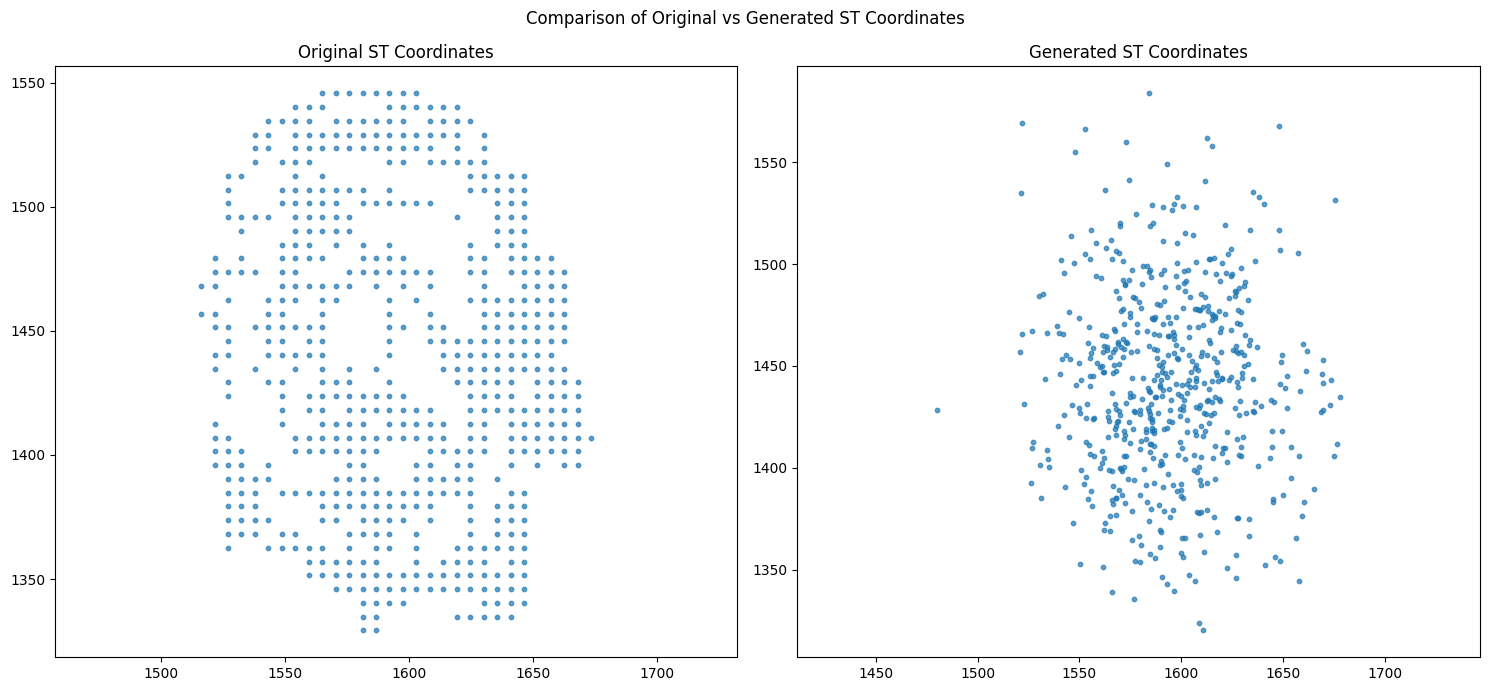

In [20]:
import matplotlib.pyplot as plt 

# Compare with original ST coordinates
def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if they're tensors
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

# Plot comparison
plot_comparison(Y_st_np, st_gen_np)

In [ ]:
sc_coords = diffusion.sample_coordinates(timesteps=800)

In [ ]:
sc_coords

In [ ]:
# sc_coords = diffusion.sample_sc_coordinates(timesteps=1000, lambda_structure=2.0)

adata.obsm['diffusion_coords'] = sc_coords.cpu().numpy()
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.set_figure_params(figsize=(10, 10))


#plot using scanypy's spatial plotting function with cell types as colors
sc.pl.embedding(adata, basis='diffusion_coords', color = 'celltype_mapped_refined',
                size=75, title='SC spatial coordinates (Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10)

In [ ]:
# After loading your data
if isinstance(Y_st, torch.Tensor):
    Y_st = Y_st.cpu().numpy()
if isinstance(X_st, torch.Tensor):
    X_st = X_st.cpu().numpy()
if isinstance(X_sc, torch.Tensor):
    X_sc = X_sc.cpu().numpy()
if isinstance(D_induced, torch.Tensor):
    D_induced = D_induced.cpu().numpy()

# Run the analysis
results = run_gnn_analysis(X_sc, D_induced)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import MDS
from tqdm import tqdm

class CoordinatePredictor(nn.Module):
    """Direct coordinate prediction model"""
    def __init__(self, gene_dim, hidden_dim=256, n_layers=4):
        super().__init__()
        
        # Input embedding
        self.gene_encoder = nn.Sequential(
            nn.Linear(gene_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # Hidden layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU()
            ) for _ in range(n_layers)
        ])
        
        # Output layer
        self.out = nn.Linear(hidden_dim, 2)  # x,y coordinates
    
    def forward(self, gene_expr):
        # Encode gene expression
        x = self.gene_encoder(gene_expr)
        
        # Process through hidden layers
        for layer in self.layers:
            x = x + layer(x)  # Residual connection
        
        # Predict coordinates
        coords = self.out(x)
        return coords

class DirectPredictionModel:
    def __init__(
        self,
        st_gene_expr,
        st_coords,
        sc_gene_expr,
        D_induced,
        device='cuda',
        hidden_dim=256
    ):
        self.device = torch.device(device)
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords_orig = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        
        # Normalize coordinates
        self.st_coords_mean = torch.mean(self.st_coords_orig, dim=0)
        self.st_coords_std = torch.std(self.st_coords_orig, dim=0)
        self.st_coords = (self.st_coords_orig - self.st_coords_mean) / (self.st_coords_std + 1e-8)
        
        # Initialize model
        self.model = CoordinatePredictor(
            gene_dim=st_gene_expr.shape[1],
            hidden_dim=hidden_dim
        ).to(self.device)
        
        # Initialize MDS for initial coordinates
        self.mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    
    def train(self, n_epochs=1000, batch_size=64, lr=1e-4, lambda_dist=10.0):
        """Train the coordinate prediction model"""
        print("Training direct coordinate prediction model...")
        
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch
            idx = torch.randperm(len(self.st_gene_expr))[:batch_size]
            gene_batch = self.st_gene_expr[idx]
            coord_batch = self.st_coords[idx]
            
            # Forward pass
            pred_coords = self.model(gene_batch)
            
            # Coordinate loss (MSE)
            coord_loss = F.mse_loss(pred_coords, coord_batch)
            
            # Distance preservation loss
            true_dist = torch.cdist(coord_batch, coord_batch)
            pred_dist = torch.cdist(pred_coords, pred_coords)
            
            # Normalize distances
            true_dist = true_dist / (true_dist.mean() + 1e-8)
            pred_dist = pred_dist / (pred_dist.mean() + 1e-8)
            
            dist_loss = F.mse_loss(pred_dist, true_dist)
            
            # Total loss
            total_loss = coord_loss + lambda_dist * dist_loss
            
            # Backprop
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            
            # Update scheduler
            scheduler.step(total_loss)
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{n_epochs}, "
                      f"Loss: {total_loss.item():.6f}, "
                      f"Coord Loss: {coord_loss.item():.6f}, "
                      f"Dist Loss: {dist_loss.item():.6f}, "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")
                
                # Test on all training data
                if epoch % 500 == 0:
                    with torch.no_grad():
                        all_pred = self.model(self.st_gene_expr)
                        all_coord_loss = F.mse_loss(all_pred, self.st_coords)
                        print(f"Full training set coord loss: {all_coord_loss.item():.6f}")
    
    def predict_sc_coordinates(self):
        """Predict coordinates for single-cell data"""
        print("Predicting SC coordinates...")
        
        # Get initial coordinates from MDS on D_induced
        print("Running MDS on D_induced for initial coordinates...")
        D_induced_np = self.D_induced.cpu().numpy()
        initial_coords = self.mds.fit_transform(D_induced_np)
        
        # Normalize initial coordinates
        initial_coords = (initial_coords - np.mean(initial_coords, axis=0)) / (np.std(initial_coords, axis=0) + 1e-8)
        initial_coords = torch.tensor(initial_coords, dtype=torch.float32).to(self.device)
        
        # Refine with model
        self.model.eval()
        with torch.no_grad():
            # Generate predicted coordinates from gene expression
            gene_pred_coords = self.model(self.sc_gene_expr)
            
            # Blend with MDS coordinates (70% model, 30% MDS to maintain global structure)
            blended_coords = 0.7 * gene_pred_coords + 0.3 * initial_coords
            
            # Refine to better match D_induced
            refined_coords = self.refine_coordinates(blended_coords, self.D_induced, n_steps=1000)
            
            # Denormalize
            denorm_coords = refined_coords * self.st_coords_std + self.st_coords_mean
        
        return denorm_coords.cpu().numpy()
    
    def refine_coordinates(self, coords, target_distances, n_steps=1000, lr=0.001):
        """Explicitly refine coordinates to match target distance matrix"""
        print("Refining coordinates to match target distances...")
        
        # Create a clone of coordinates that requires gradients
        refined = coords.clone().detach().requires_grad_(True)
        
        # Optimizer for coordinate updates
        optimizer = torch.optim.Adam([refined], lr=lr)
        
        # Refinement loop
        for step in tqdm(range(n_steps)):
            # Compute current distances
            current_dist = torch.cdist(refined, refined)
            
            # Normalize distances
            target_norm = target_distances / (target_distances.mean() + 1e-8)
            current_norm = current_dist / (current_dist.mean() + 1e-8)
            
            # Distance loss
            loss = F.mse_loss(current_norm, target_norm)
            
            # Backprop and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print progress
            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss.item():.6f}")
        
        return refined.detach()
    
    def generate_st_coordinates(self):
        """Generate ST coordinates to evaluate model"""
        print("Generating ST coordinates for evaluation...")
        
        self.model.eval()
        with torch.no_grad():
            pred_coords = self.model(self.st_gene_expr)
            denorm_coords = pred_coords * self.st_coords_std + self.st_coords_mean
        
        return denorm_coords.cpu().numpy()

In [13]:
# Initialize the model
direct_model = DirectPredictionModel(
    st_gene_expr=X_st,
    st_coords=Y_st,
    sc_gene_expr=X_sc,
    D_induced=D_induced,
    device="cuda",
    hidden_dim=256
)

# Train the model
direct_model.train(n_epochs=1000, batch_size=64, lr=1e-4, lambda_dist=10.0)

# Evaluate on ST data first
st_gen_coords = direct_model.generate_st_coordinates()

# Plot comparison
plot_comparison(Y_st, st_gen_coords, "Direct Model: Original vs Generated ST Coordinates")

# If ST results look good, generate SC coordinates
sc_coords = direct_model.predict_sc_coordinates()

# Visualize SC coordinates
adata.obsm['direct_pred_coords'] = sc_coords
sc.pl.embedding(adata, basis='direct_pred_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (Direct Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10)

/tmp/ipykernel_3060191/4175543857.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_3060191/4175543857.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_3060191/4175543857.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)


Training direct coordinate prediction model...


AttributeError: module 'torch.optim' has no attribute 'ReduceLROnPlateau'

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import MDS
from tqdm import tqdm

class CoordinatePredictor(nn.Module):
    """Direct coordinate prediction model"""
    def __init__(self, gene_dim, hidden_dim=256, n_layers=4):
        super().__init__()
        
        # Input embedding
        self.gene_encoder = nn.Sequential(
            nn.Linear(gene_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # Hidden layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU()
            ) for _ in range(n_layers)
        ])
        
        # Output layer
        self.out = nn.Linear(hidden_dim, 2)  # x,y coordinates
    
    def forward(self, gene_expr):
        # Encode gene expression
        x = self.gene_encoder(gene_expr)
        
        # Process through hidden layers
        for layer in self.layers:
            x = x + layer(x)  # Residual connection
        
        # Predict coordinates
        coords = self.out(x)
        return coords

class DirectPredictionModel:
    def __init__(
        self,
        st_gene_expr,
        st_coords,
        sc_gene_expr,
        D_induced,
        device='cuda',
        hidden_dim=256
    ):
        self.device = torch.device(device)
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords_orig = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        
        # Normalize coordinates
        self.st_coords_mean = torch.mean(self.st_coords_orig, dim=0)
        self.st_coords_std = torch.std(self.st_coords_orig, dim=0)
        self.st_coords = (self.st_coords_orig - self.st_coords_mean) / (self.st_coords_std + 1e-8)
        
        # Initialize model
        self.model = CoordinatePredictor(
            gene_dim=st_gene_expr.shape[1],
            hidden_dim=hidden_dim
        ).to(self.device)
        
        # Initialize MDS for initial coordinates
        self.mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    
    def train(self, n_epochs=1000, batch_size=64, lr=1e-4, lambda_dist=10.0):
        """Train the coordinate prediction model"""
        print("Training direct coordinate prediction model...")
        
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        # Simple learning rate scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch
            idx = torch.randperm(len(self.st_gene_expr))[:batch_size].to(self.device)
            gene_batch = self.st_gene_expr[idx]
            coord_batch = self.st_coords[idx]
            
            # Forward pass
            pred_coords = self.model(gene_batch)
            
            # Coordinate loss (MSE)
            coord_loss = F.mse_loss(pred_coords, coord_batch)
            
            # Distance preservation loss
            true_dist = torch.cdist(coord_batch, coord_batch)
            pred_dist = torch.cdist(pred_coords, pred_coords)
            
            # Normalize distances
            true_dist = true_dist / (true_dist.mean() + 1e-8)
            pred_dist = pred_dist / (pred_dist.mean() + 1e-8)
            
            dist_loss = F.mse_loss(pred_dist, true_dist)
            
            # Total loss
            total_loss = coord_loss + lambda_dist * dist_loss
            
            # Backprop
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            
            # Update scheduler
            scheduler.step()
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{n_epochs}, "
                      f"Loss: {total_loss.item():.6f}, "
                      f"Coord Loss: {coord_loss.item():.6f}, "
                      f"Dist Loss: {dist_loss.item():.6f}, "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")
                
                # Test on all training data
                if epoch % 500 == 0:
                    with torch.no_grad():
                        all_pred = self.model(self.st_gene_expr)
                        all_coord_loss = F.mse_loss(all_pred, self.st_coords)
                        print(f"Full training set coord loss: {all_coord_loss.item():.6f}")
    
    def predict_sc_coordinates(self):
        """Predict coordinates for single-cell data"""
        print("Predicting SC coordinates...")
        
        # Get initial coordinates from MDS on D_induced
        print("Running MDS on D_induced for initial coordinates...")
        D_induced_np = self.D_induced.cpu().numpy()
        initial_coords = self.mds.fit_transform(D_induced_np)
        
        # Normalize initial coordinates
        initial_coords = (initial_coords - np.mean(initial_coords, axis=0)) / (np.std(initial_coords, axis=0) + 1e-8)
        initial_coords = torch.tensor(initial_coords, dtype=torch.float32).to(self.device)
        
        # Refine with model
        self.model.eval()
        # with torch.no_grad():
        # Generate predicted coordinates from gene expression
        gene_pred_coords = self.model(self.sc_gene_expr)
        
        # Blend with MDS coordinates (70% model, 30% MDS to maintain global structure)
        # blended_coords = 0.7 * gene_pred_coords + 0.3 * initial_coords
        blended_coords = gene_pred_coords
        # blended_coords = initial_coords

        
        # Refine to better match D_induced
        # refined_coords = self.refine_coordinates(blended_coords, self.D_induced, n_steps=1500)
        refined_coords = blended_coords
        
        # Denormalize
        denorm_coords = refined_coords * self.st_coords_std + self.st_coords_mean
        
        # return denorm_coords.cpu().numpy()
        return denorm_coords.detach().cpu().numpy()
    
    def refine_coordinates(self, coords, target_distances, n_steps=1000, lr=0.001):
        """Explicitly refine coordinates to match target distance matrix"""
        print("Refining coordinates to match target distances...")
        
        # Create a clone of coordinates that requires gradients
        refined = coords.clone().detach().requires_grad_(True)
        
        # Optimizer for coordinate updates
        optimizer = torch.optim.Adam([refined], lr=lr)
        
        # Convert target_distances to a detached tensor to avoid gradient issues
        target_distances = target_distances.clone().detach()
        
        # Refinement loop
        for step in tqdm(range(n_steps)):
            # Compute current distances
            current_dist = torch.cdist(refined, refined)
            
            # Normalize distances
            target_norm = target_distances / (target_distances.mean() + 1e-8)
            current_norm = current_dist / (current_dist.mean() + 1e-8)
            
            # Distance loss - use Mean Squared Error directly on the tensors
            loss = ((current_norm - target_norm) ** 2).mean()
            
            # Backprop and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print progress
            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss.item():.6f}")
        
        return refined.detach()
    
    def generate_st_coordinates(self):
        """Generate ST coordinates to evaluate model"""
        print("Generating ST coordinates for evaluation...")
        
        self.model.eval()
        with torch.no_grad():
            pred_coords = self.model(self.st_gene_expr)
            denorm_coords = pred_coords * self.st_coords_std + self.st_coords_mean
        
        return denorm_coords.cpu().numpy()

/tmp/ipykernel_3060191/1729928695.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_3060191/1729928695.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_3060191/1729928695.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)


Training direct coordinate prediction model...
Epoch 0/1500, Loss: 7.245383, Coord Loss: 1.734377, Dist Loss: 0.551101, LR: 0.000100
Full training set coord loss: 1.362030
Epoch 100/1500, Loss: 1.060644, Coord Loss: 1.004974, Dist Loss: 0.005567, LR: 0.000100
Epoch 200/1500, Loss: 1.071577, Coord Loss: 1.027987, Dist Loss: 0.004359, LR: 0.000050
Epoch 300/1500, Loss: 0.950369, Coord Loss: 0.932324, Dist Loss: 0.001805, LR: 0.000050
Epoch 400/1500, Loss: 1.076475, Coord Loss: 1.058712, Dist Loss: 0.001776, LR: 0.000025
Epoch 500/1500, Loss: 1.014845, Coord Loss: 1.007110, Dist Loss: 0.000774, LR: 0.000025
Full training set coord loss: 0.991498
Epoch 600/1500, Loss: 1.038342, Coord Loss: 1.032528, Dist Loss: 0.000581, LR: 0.000013
Epoch 700/1500, Loss: 1.026202, Coord Loss: 1.022236, Dist Loss: 0.000397, LR: 0.000013
Epoch 800/1500, Loss: 0.968972, Coord Loss: 0.966200, Dist Loss: 0.000277, LR: 0.000006
Epoch 900/1500, Loss: 0.978969, Coord Loss: 0.975462, Dist Loss: 0.000351, LR: 0.0000

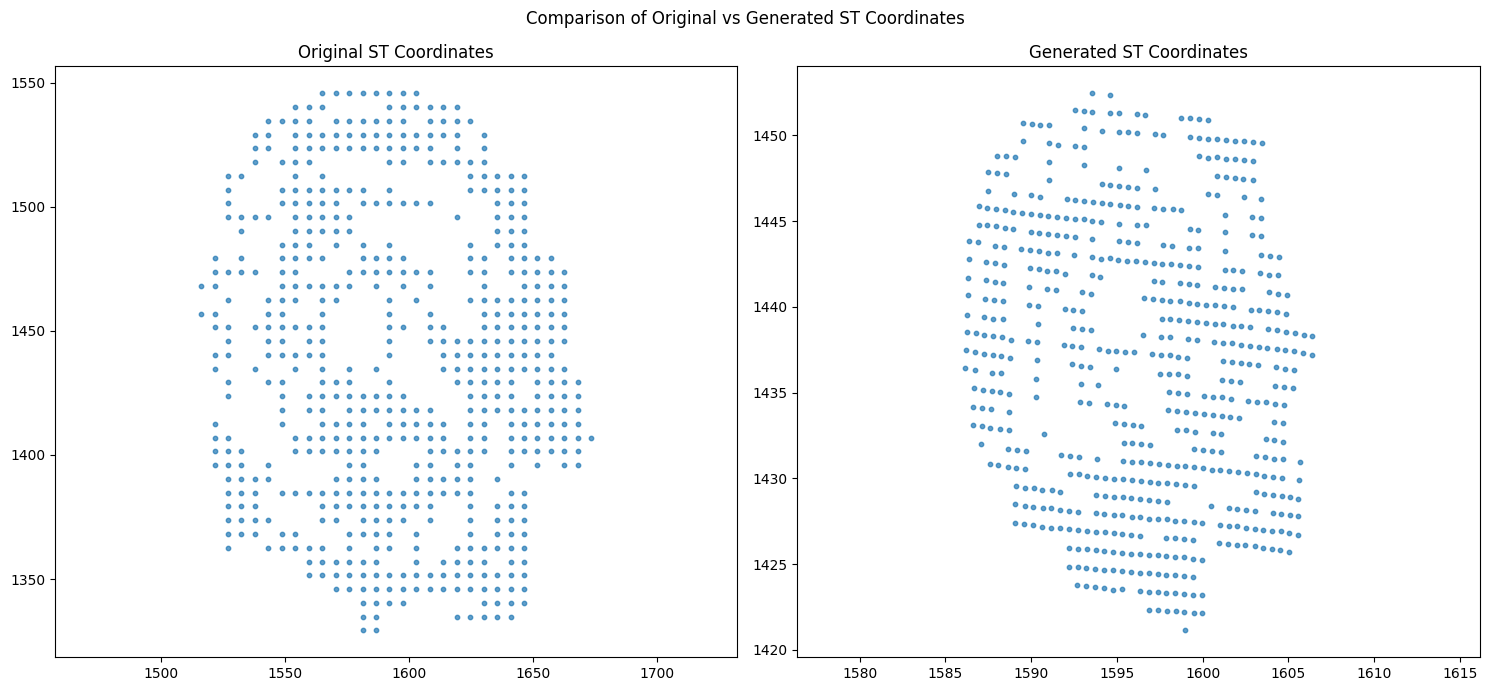

Predicting SC coordinates...
Running MDS on D_induced for initial coordinates...


In [36]:
import matplotlib.pyplot as plt 

# Initialize the model
direct_model = DirectPredictionModel(
    st_gene_expr=X_st,
    st_coords=Y_st,
    sc_gene_expr=X_sc,
    D_induced=D_induced,
    device="cuda",
    hidden_dim=256
)

# Train the model
direct_model.train(n_epochs=1500, batch_size=128, lr=1e-4, lambda_dist=10.0)

# Evaluate on ST data first
st_gen_coords = direct_model.generate_st_coordinates()

# Plot comparison
def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if needed
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

plot_comparison(Y_st_np, st_gen_coords)

# If ST results look good, generate SC coordinates
sc_coords = direct_model.predict_sc_coordinates()


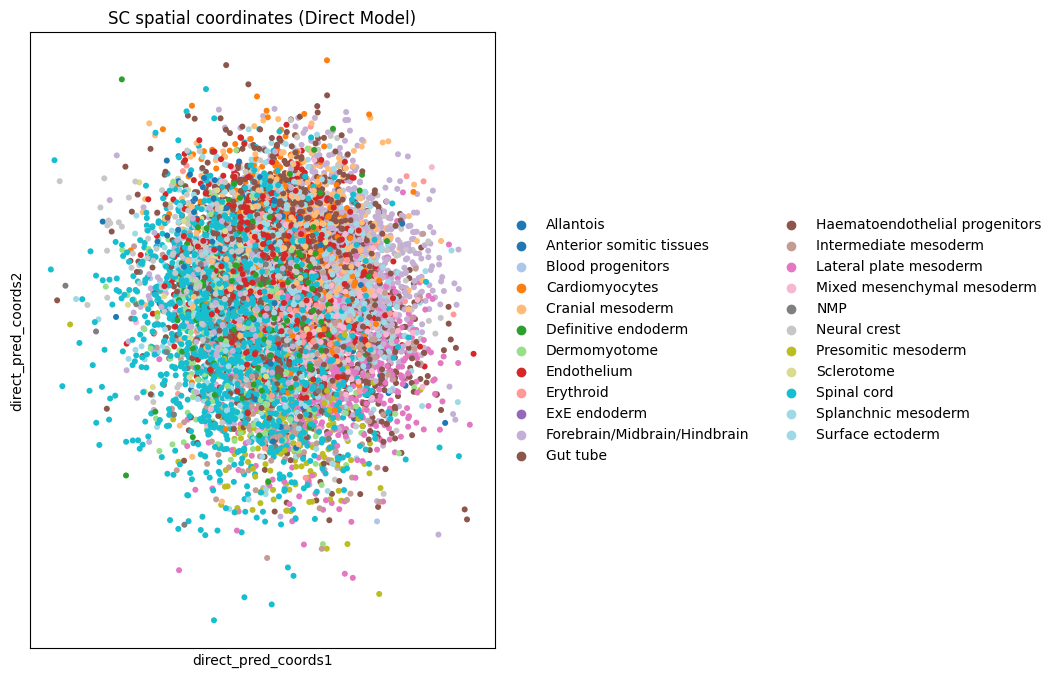

In [37]:
# Store in AnnData and visualize
adata.obsm['direct_pred_coords'] = sc_coords
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 8))  # your preferred size

sc.pl.embedding(
    adata,
    basis='direct_pred_coords',
    color='celltype_mapped_refined',
    size=75,
    title='SC spatial coordinates (Direct Model)',
    palette='tab20',
    legend_loc='right margin',
    legend_fontsize=10,
    ax=ax,                 # pass your axes
    show=True             # or False, depending on your workflow
)



In [38]:
sc_coords

array([[1603.2665, 1430.1033],
       [1589.4669, 1428.835 ],
       [1607.3339, 1431.1593],
       ...,
       [1591.1161, 1444.3701],
       [1586.261 , 1443.8108],
       [1589.2588, 1438.3882]], dtype=float32)

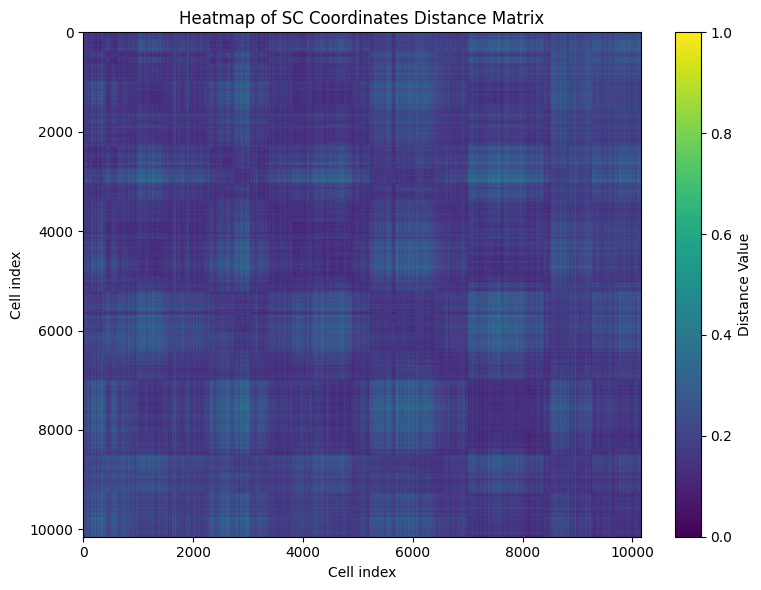

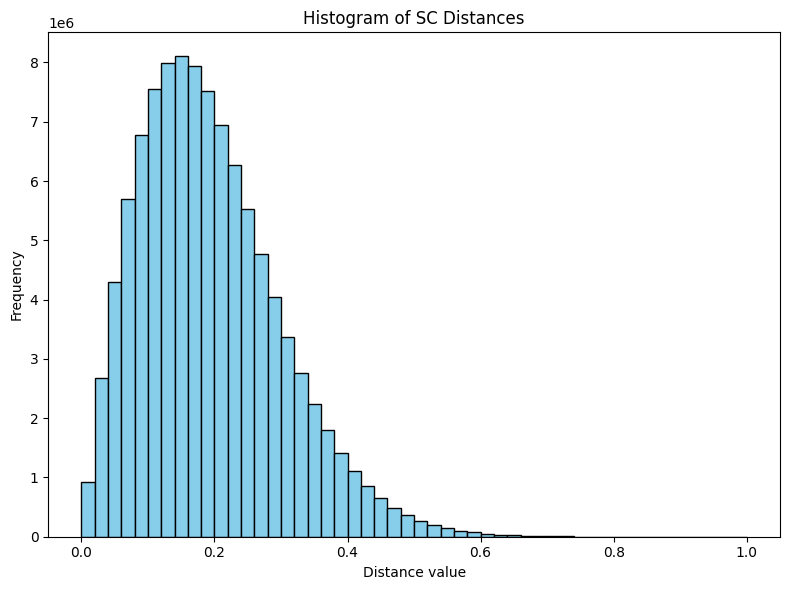

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Assuming sc_coords is your tensor of SC coordinates
# Convert to numpy array if it's a torch tensor
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().detach().numpy()
else:
    sc_coords_np = sc_coords

# Calculate Euclidean distance matrix
# Option 1: Using torch directly
with torch.no_grad():
    if isinstance(sc_coords, torch.Tensor):
        sc_dist_matrix = torch.cdist(sc_coords, sc_coords, p=2)
        sc_dist_matrix_np = sc_dist_matrix.cpu().numpy()
    else:
        # Option 2: Using scipy (more efficient for large matrices)
        pairwise_distances = pdist(sc_coords_np, metric='euclidean')
        sc_dist_matrix_np = squareform(pairwise_distances)

# Normalize the distance matrix
min_val = sc_dist_matrix_np.min()
max_val = sc_dist_matrix_np.max()
# Option 1: Min-max normalization
normalized_matrix = (sc_dist_matrix_np - min_val) / (max_val - min_val)
# Option 2: Max normalization
# normalized_matrix = sc_dist_matrix_np / max_val

# Plot a heatmap of the distance matrix
plt.figure(figsize=(8, 6))
plt.imshow(normalized_matrix, cmap='viridis', aspect='auto')
plt.title("Heatmap of SC Coordinates Distance Matrix")
plt.colorbar(label='Distance Value')
plt.xlabel("Cell index")
plt.ylabel("Cell index")
plt.tight_layout()
plt.show()

# Plot a histogram of the distance values
plt.figure(figsize=(8, 6))
plt.hist(normalized_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of SC Distances")
plt.xlabel("Distance value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# You can also visualize a subset for better clarity
# For example, first 500x500 cells if the matrix is too large
# subset_size = min(500, normalized_matrix.shape[0])
# plt.figure(figsize=(10, 8))
# plt.imshow(normalized_matrix[:subset_size, :subset_size], cmap='viridis', aspect='auto')
# plt.title(f"Heatmap of SC Distance Matrix (First {subset_size}x{subset_size} cells)")
# plt.colorbar(label='Distance Value')
# plt.xlabel("Cell index")
# plt.ylabel("Cell index")
# plt.tight_layout()
# plt.show()

# # Compare with D_induced (if available)
# if 'D_induced' in locals() or 'D_induced' in globals():
#     if isinstance(D_induced, torch.Tensor):
#         D_induced_np = D_induced.cpu().detach().numpy()
#     else:
#         D_induced_np = D_induced
    
#     D_induced_np = D_induced_np / D_induced_np.max()  # Normalize
    
#     # Plot correlation between distance matrices if sizes match
#     if D_induced_np.shape == normalized_matrix.shape:
#         plt.figure(figsize=(8, 6))
#         plt.scatter(
#             D_induced_np.flatten(), 
#             normalized_matrix.flatten(), 
#             alpha=0.1, s=1
#         )
#         plt.title("Correlation: D_induced vs SC Coordinates Distance")
#         plt.xlabel("D_induced distance")
#         plt.ylabel("SC coordinates distance")
#         plt.tight_layout()
#         plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from tqdm import tqdm
import os
import time

class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512, 256, 128], dp=0):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        self.dp = nn.Dropout(dp)
        
    def forward(self, x, isdp=False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def gaussian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        return delta.dot(delta.T)

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.gaussian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            return torch.mean(XX + YY - XY - YX)

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class ImprovedDiffusionModel(nn.Module):
    def __init__(
        self,
        n_genes,
        embedding_dim=128,
        hidden_dim=256,
        n_blocks=4,
        dp=0.1
    ):
        super().__init__()
        
        # Feature encoder (shared between ST and SC data)
        self.feature_encoder = FeatureNet(n_genes, n_embedding=[512, 256, embedding_dim], dp=dp)
        
        # Time embedding for diffusion
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Embedding to hidden dim projection
        self.emb_proj = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Coordinate embedding
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Main network with residual blocks
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            self.blocks.append(
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.SiLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.SiLU()
                )
            )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        )
    
    def forward(self, coords, t, features):
        # Encode features with the shared encoder
        feat_emb = self.feature_encoder(features, isdp=True)
        feat_hidden = self.emb_proj(feat_emb)
        
        # Encode time steps
        t_emb = self.time_embed(t)
        
        # Encode coordinates
        coord_emb = self.coord_encoder(coords)
        
        # Combine all inputs
        h = coord_emb + t_emb + feat_hidden
        
        # Process through residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Predict noise
        return self.final(h)

class ImprovedDiffusionTrainer:
    def __init__(
        self,
        st_gene_expr,
        st_coords,
        st_dist_matrix,
        sc_gene_expr, 
        D_induced,
        outf='./diffusion_output',
        device='cuda',
        embedding_dim=128,
        hidden_dim=256,
        n_blocks=4,
        dp=0.1,
        n_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02
    ):
        self.device = torch.device(device)
        
        # Create output directory
        self.outf = outf
        if not os.path.exists(outf):
            os.makedirs(outf)
        
        self.train_log = os.path.join(outf, 'train.log')
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords_orig = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # Store distance matrices
        self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)
        self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        
        # Normalize coordinates
        coords_min = self.st_coords_orig.min(dim=0)[0]
        coords_max = self.st_coords_orig.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords = 2 * (self.st_coords_orig - coords_min) / coords_range - 1
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range
        
        # Initialize model
        self.model = ImprovedDiffusionModel(
            n_genes=st_gene_expr.shape[1],
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            n_blocks=n_blocks,
            dp=dp
        ).to(self.device)
        
        # Setup noise schedule
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)
        
        # Store dimensions
        self.n_genes = st_gene_expr.shape[1]
        self.embedding_dim = embedding_dim
        
        # Setup losses
        self.mmd_loss = MMDLoss()
        
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting diffusion model training\n")
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns diffusion noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def compute_adjacency_matrix(self, distances, sigma=3.0):
        """Convert distance matrix to adjacency matrix using Gaussian kernel"""
        weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
        # Zero out self-connections
        weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
        # Normalize rows to sum to 1
        row_sums = weights.sum(dim=1, keepdim=True)
        adjacency = weights / (row_sums + 1e-8)
        return adjacency
    
    def train(self, n_epochs=3000, batch_size=256, lambda_struct=10.0, lambda_mmd=0.5, lr=1e-4):
        """Train the diffusion model with structural and MMD losses"""
        print("Starting improved diffusion model training...")
        
        with open(self.train_log, 'a') as f:
            f.write(f"Training parameters: n_epochs={n_epochs}, batch_size={batch_size}, "
                   f"lambda_struct={lambda_struct}, lambda_mmd={lambda_mmd}, lr={lr}\n")
        
        # Compute adjacency matrix for ST data
        st_adj_matrix = self.compute_adjacency_matrix(self.st_dist_matrix, sigma=3.0)
        
        # Setup optimizer
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-5)
        
        # Learning rate scheduler
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=500, T_mult=1, eta_min=1e-6
        )
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Pre-compute shared gene expression embeddings for ST data
        # These will be updated during training, but computing once saves time
        self.model.eval()
        with torch.no_grad():
            st_embeddings = self.model.feature_encoder(self.st_gene_expr, isdp=False)
        
        # Training loop
        for epoch in range(n_epochs):
            self.model.train()
            
            # Random batch of ST data
            idx = torch.randint(0, len(self.st_coords), (batch_size,), device=self.device)
            coords = self.st_coords[idx]
            features = self.st_gene_expr[idx]
            
            # Sub-adjacency matrix for this batch
            sub_adj = st_adj_matrix[idx][:, idx]
            
            # Mix of different timesteps for better coverage
            if np.random.random() < 0.3:
                # Focus on early timesteps (high noise)
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                # Focus on late timesteps (low noise, more structure)
                t = torch.randint(0, int(0.3 * self.n_timesteps), (batch_size,), device=self.device)
            else:
                # Random timesteps across the range
                t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Predict noise
            pred_noise = self.model(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Diffusion loss (noise prediction)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Get embeddings for the current batch
            batch_embeddings = self.model.feature_encoder(features, isdp=True)
            
            # Sample from SC data for MMD loss
            sc_idx = torch.randint(0, len(self.sc_gene_expr), (min(batch_size, 1000),), device=self.device)
            sc_features = self.sc_gene_expr[sc_idx]
            
            # Get SC embeddings
            sc_embeddings = self.model.feature_encoder(sc_features, isdp=False)
            
            # MMD loss between ST and SC embeddings to align domains
            mmd_loss = self.mmd_loss(batch_embeddings, sc_embeddings)
            
            # Estimate denoised coordinates
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Structure loss using distances for stability
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            true_distances = torch.cdist(coords, coords, p=2)
            
            # Normalize distances for more stable comparison
            pred_distances = pred_distances / (pred_distances.mean() + 1e-8)
            true_distances = true_distances / (true_distances.mean() + 1e-8)
            
            # Direct MSE on distances
            struct_loss = F.mse_loss(pred_distances, true_distances)
            
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss + lambda_mmd * mmd_loss
            
            # Optimize
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)  # Grad clipping
            optimizer.step()
            scheduler.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_loss
                }
                # Save best model
                torch.save(best_state, os.path.join(self.outf, 'best_model.pt'))
            
            # Log and print progress
            if epoch % 100 == 0:
                log_msg = (f"Epoch {epoch}/{n_epochs}, "
                        f"Loss: {total_loss.item():.6f}, "
                        f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                        f"Structure Loss: {struct_loss.item():.6f}, "
                        f"MMD Loss: {mmd_loss.item():.6f}, "
                        f"LR: {scheduler.get_last_lr()[0]:.6f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'loss': total_loss.item()
                    }, os.path.join(self.outf, f'checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model at the end
        if best_state is not None:
            self.model.load_state_dict(best_state['model_state_dict'])
            print(f"Restored best model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        # Save final model
        torch.save({
            'model_state_dict': self.model.state_dict(),
        }, os.path.join(self.outf, 'final_model.pt'))
        
        print("Training complete!")
        return best_state
    
    def generate_st_coordinates(self, timesteps=None):
        """Generate coordinates for ST data to evaluate model quality"""
        print("Generating ST coordinates for evaluation...")
        self.model.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_spots = len(self.st_gene_expr)
        
        # Start from random noise
        x = torch.randn(n_spots, 2, device=self.device)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc="Generating ST coordinates"):
            # Create timestep tensor
            time_tensor = torch.ones(n_spots, 1, device=self.device) * t / timesteps
            
            # Predict noise
            pred_noise = self.model(
                x, 
                time_tensor, 
                self.st_gene_expr
            )
            
            # Get parameters for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(x)
        
        print("Generation complete!")
        return st_gen_coords
    
    def sample_sc_coordinates(self, timesteps=None, use_structure_guidance=True):
        """Sample coordinates for SC data using the trained diffusion model"""
        print("Sampling SC coordinates...")
        self.model.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        
        # Start from random noise
        x = torch.randn(n_cells, 2, device=self.device)
        
        # Calculate target adjacency matrix from D_induced for structure guidance
        target_adj = self.compute_adjacency_matrix(self.D_induced, sigma=3.0)
        
        # Gradually denoise
        for t in tqdm(range(timesteps-1, -1, -1), desc="Sampling SC coordinates"):
            # Create timestep tensor
            time_tensor = torch.ones(n_cells, 1, device=self.device) * t / timesteps
            
            # Predict noise
            pred_noise = self.model(
                x, 
                time_tensor, 
                self.sc_gene_expr
            )
            
            # Get parameters for this timestep
            alpha_t = self.noise_schedule['alphas'][t]
            alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
            beta_t = self.noise_schedule['betas'][t]
            
            # Apply noise (except for last step)
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
            
            # Update sample with reverse diffusion step
            x = (1 / torch.sqrt(alpha_t)) * (
                x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
            ) + torch.sqrt(beta_t) * noise
            
            # Apply structure guidance in later steps
            if use_structure_guidance and t < timesteps * 0.7 and t % 5 == 0:
                # Adjust coordinates to better respect D_induced structure
                x = self.adjust_coordinates_to_match_structure(x, target_adj, t, timesteps)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(x)
        
        print("Sampling complete!")
        return sc_coords
    
    def adjust_coordinates_to_match_structure(self, coords, target_adj, t, timesteps, lr=0.05):
        """Adjust coordinates to better match target adjacency structure"""
        # Current adjacency
        cur_dist = torch.cdist(coords, coords, p=2)
        cur_adj = self.compute_adjacency_matrix(cur_dist, sigma=3.0)
        
        # Adjust learning rate based on timestep (smaller adjustments near the end)
        lr_scale = 0.1 * (t / timesteps) + 0.01
        
        # Compute adjustment direction
        diff = cur_adj - target_adj
        
        # For each point, determine how it should move relative to all other points
        # Direction vectors between all pairs
        coord_i = coords.unsqueeze(1)  # [n, 1, 2]
        coord_j = coords.unsqueeze(0)  # [1, n, 2]
        directions = coord_i - coord_j  # [n, n, 2]
        
        # Normalize directions
        distances = torch.norm(directions, dim=2, keepdim=True)
        norm_directions = directions / (distances + 1e-8)
        
        # Scale directions by adjacency difference
        delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
        
        # Sum influences from all other points
        adjustments = -delta.sum(dim=1)  # [n, 2]
        
        # Apply adjustments with learning rate
        adjusted_coords = coords - lr_scale * lr * adjustments
        
        return adjusted_coords
    
    def denormalize_coordinates(self, normalized_coords):
        """Convert normalized coordinates back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords

In [12]:
# Initialize the model
diffusion_trainer = ImprovedDiffusionTrainer(
    st_gene_expr=X_st,
    st_coords=Y_st,
    st_dist_matrix=D_st,
    sc_gene_expr=X_sc, 
    D_induced=D_induced,
    outf='./diffusion_output',
    device='cuda',
    embedding_dim=128,
    hidden_dim=256,
    n_blocks=4,
    dp=0.1,
    n_timesteps=800,
    beta_start=1e-4,
    beta_end=0.02
)

# Train the model
diffusion_trainer.train(
    n_epochs=1500,
    batch_size=256,
    lambda_struct=10.0,  # Higher weight on structure loss
    lambda_mmd=0.5,      # MMD loss to align ST and SC embeddings
    lr=5e-5              # Lower learning rate for stability
)

# Test with ST data first
st_gen_coords = diffusion_trainer.generate_st_coordinates(timesteps=800)

# Visualize ST results
def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if needed
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

# Plot ST comparison
plot_comparison(Y_st_np, st_gen_np)

# If ST results look good, generate SC coordinates
sc_coords = diffusion_trainer.sample_sc_coordinates(
    timesteps=800,
    use_structure_guidance=True  # Enable structure guidance during sampling
)

# Visualize SC coordinates
adata.obsm['diffusion_coords'] = sc_coords
sc.pl.embedding(adata, basis='diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10)

/tmp/ipykernel_2659836/3218371266.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2659836/3218371266.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2659836/3218371266.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_dist_matrix = torch.tensor(st_dist_matrix, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2659836/3

Starting improved diffusion model training...
Epoch 0/1500, Loss: 3.898763, Diffusion Loss: 1.043287, Structure Loss: 0.275476, MMD Loss: 0.201425, LR: 0.000050
Epoch 100/1500, Loss: 5.960950, Diffusion Loss: 0.253474, Structure Loss: 0.565970, MMD Loss: 0.095543, LR: 0.000045
Epoch 200/1500, Loss: 4.750689, Diffusion Loss: 0.311246, Structure Loss: 0.440953, MMD Loss: 0.059831, LR: 0.000033
Epoch 300/1500, Loss: 4.159668, Diffusion Loss: 0.264805, Structure Loss: 0.387162, MMD Loss: 0.046478, LR: 0.000018
Epoch 400/1500, Loss: 1.055082, Diffusion Loss: 0.313545, Structure Loss: 0.071793, MMD Loss: 0.047205, LR: 0.000006
Epoch 500/1500, Loss: 1.037434, Diffusion Loss: 0.324458, Structure Loss: 0.069224, MMD Loss: 0.041463, LR: 0.000050
Epoch 600/1500, Loss: 15.629826, Diffusion Loss: 0.237284, Structure Loss: 1.537501, MMD Loss: 0.035055, LR: 0.000045
Epoch 700/1500, Loss: 0.857856, Diffusion Loss: 0.259742, Structure Loss: 0.057965, MMD Loss: 0.036929, LR: 0.000033
Epoch 800/1500, Los

Generating ST coordinates:  91%|█████████▏| 730/800 [00:01<00:00, 384.93it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 19.69 GiB total capacity; 17.27 GiB already allocated; 1.56 MiB free; 19.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

/tmp/ipykernel_2570361/3369038642.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)


Training improved diffusion model...
Epoch 0/3500, Loss: 18.714928, Diffusion Loss: 1.038969, Dist Loss: 0.883798, Gene LR: 0.000100, Denoiser LR: 0.000100
Epoch 100/3500, Loss: 12.517702, Diffusion Loss: 1.012834, Dist Loss: 0.575243, Gene LR: 0.000100, Denoiser LR: 0.000100
Epoch 200/3500, Loss: 10.881454, Diffusion Loss: 0.589676, Dist Loss: 0.514589, Gene LR: 0.000099, Denoiser LR: 0.000099
Epoch 300/3500, Loss: 11.023948, Diffusion Loss: 0.696102, Dist Loss: 0.516392, Gene LR: 0.000098, Denoiser LR: 0.000098
Epoch 400/3500, Loss: 5.839777, Diffusion Loss: 0.756406, Dist Loss: 0.254169, Gene LR: 0.000097, Denoiser LR: 0.000097
Epoch 500/3500, Loss: 7.392871, Diffusion Loss: 1.323058, Dist Loss: 0.303491, Gene LR: 0.000095, Denoiser LR: 0.000095
Validating on all ST data...
Validation Diffusion Loss: 1.108037
Epoch 600/3500, Loss: 6.438394, Diffusion Loss: 1.063776, Dist Loss: 0.268731, Gene LR: 0.000093, Denoiser LR: 0.000093
Epoch 700/3500, Loss: 5.245326, Diffusion Loss: 0.840872

100%|██████████| 1000/1000 [00:00<00:00, 1134.68it/s]


Generation complete!


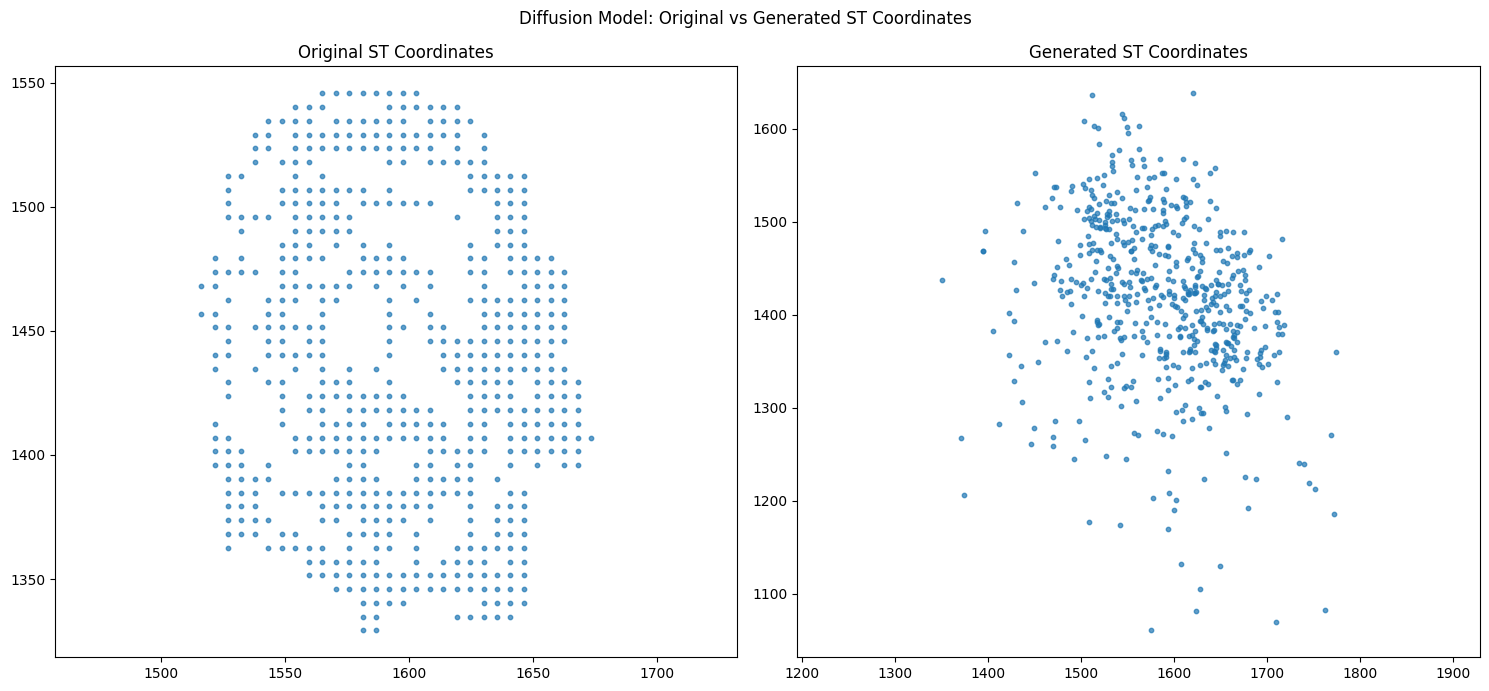

Sampling coordinates for SC data...


100%|██████████| 1000/1000 [00:16<00:00, 60.05it/s]

Sampling complete!


ValueError: Obsm 'diffusion_coords' needs to be of one of <class 'numpy.ndarray'>, <class 'numpy.ma.core.MaskedArray'>, <class 'scipy.sparse._csr.csr_matrix'>, <class 'scipy.sparse._csc.csc_matrix'>, <class 'scipy.sparse._base.sparray'>, <class 'anndata.compat.AwkArray'>, <class 'h5py._hl.dataset.Dataset'>, <class 'anndata.compat.ZarrArray'>, <class 'anndata.compat.ZappyArray'>, <class 'anndata.abc.CSRDataset'>, <class 'anndata.abc.CSCDataset'>, <class 'anndata.compat.DaskArray'>, <class 'anndata.compat.CupyArray'>, or <class 'anndata.compat.CupySparseMatrix'>, not <class 'torch.Tensor'>.

In [47]:
# Initialize the model
diffusion_model = ImprovedDiffusionModel(
    st_gene_expr=X_st,
    st_coords=Y_st,
    D_st=D_st,
    sc_gene_expr=X_sc,
    D_induced=D_induced,
    device="cuda",
    n_timesteps=1000,
    beta_start=1e-4,
    beta_end=0.02,
    gene_emb_dim=128
)

# Train the model
diffusion_model.train(
    n_epochs=3500,
    batch_size=128,
    lambda_dist=20.0
)

# First validate on ST data to ensure the model is working
st_gen_coords = diffusion_model.generate_st_coordinates()

def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):

    # Convert to numpy if they're tensors
    if isinstance(original_coords, torch.Tensor):
        original_coords = original_coords.cpu().numpy()
    else:
        original_coords = original_coords

    if isinstance(generated_coords, torch.Tensor):
        generated_coords = generated_coords.cpu().numpy()
    else:
        generated_coords = generated_coords
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



# Plot comparison to check model quality
plot_comparison(Y_st, st_gen_coords, "Diffusion Model: Original vs Generated ST Coordinates")

# If ST results look good, sample SC coordinates
sc_coords = diffusion_model.sample_sc_coordinates()

# Visualize SC coordinates
adata.obsm['diffusion_coords'] = sc_coords
sc.pl.embedding(adata, basis='diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10)

In [46]:
sc_coords

tensor([[1530.1332, 1532.1166],
        [1501.3688, 1456.9062],
        [1637.1583, 1275.3499],
        ...,
        [1453.7629, 1383.8918],
        [1503.0107, 1451.6843],
        [1664.0952, 1462.8844]], device='cuda:0')

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from tqdm import tqdm
import os
import time
import scipy

class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512, 256, 128], dp=0):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        self.dp = nn.Dropout(dp)
        
    def forward(self, x, isdp=False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class STEMDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        D_st,
        sc_gene_expr,
        D_induced=None,
        outf='./diffusion_output',
        device='cuda',
        n_genes=None,
        n_embedding=[512, 256, 128],
        hidden_dim=256,
        dp=0.1,
        n_timesteps=800,
        beta_start=1e-4,
        beta_end=0.02,
        sigma=3.0,
        alpha=0.8,
        mmdbatch=1000,
        batch_size=256
    ):
        self.device = torch.device(device)
        
        # Create output directory
        self.outf = outf
        if not os.path.exists(outf):
            os.makedirs(outf)
        
        self.train_log = os.path.join(outf, 'train.log')
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # Store distance matrices
        self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
        if D_induced is not None:
            self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        else:
            self.D_induced = None
        
        # Normalize coordinates for diffusion model
        coords_min = self.st_coords.min(dim=0)[0]
        coords_max = self.st_coords.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords_norm = 2 * (self.st_coords - coords_min) / coords_range - 1
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range
        
        # STEM parameters
        self.n_genes = n_genes or st_gene_expr.shape[1]
        self.sigma = sigma
        self.alpha = alpha
        self.mmdbatch = mmdbatch
        self.batch_size = batch_size
        
        # Initialize feature encoder (shared between ST and SC data)
        self.netE = FeatureNet(self.n_genes, n_embedding=n_embedding, dp=dp).to(self.device)
        
        # Initialize diffusion model components
        
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ).to(self.device)
        
        # Coordinate encoder
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Feature to hidden projection
        self.feat_proj = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Main network blocks
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            ).to(self.device) for _ in range(4)
        ])
        
        # Output layer
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        ).to(self.device)
        
        # Setup optimizers and losses
        self.optimizer_E = torch.optim.AdamW(self.netE.parameters(), lr=0.002)
        self.scheduler_E = lr_scheduler.StepLR(optimizer=self.optimizer_E, step_size=200, gamma=0.5)
        
        diffusion_params = list(self.time_embed.parameters()) + \
                           list(self.coord_encoder.parameters()) + \
                           list(self.feat_proj.parameters()) + \
                           list(self.blocks.parameters()) + \
                           list(self.final.parameters())
        
        self.optimizer_diff = torch.optim.AdamW(diffusion_params, lr=1e-4, weight_decay=1e-6)
        self.scheduler_diff = lr_scheduler.CosineAnnealingLR(self.optimizer_diff, T_max=3000, eta_min=1e-6)
        
        self.mmd_fn = MMDLoss()
        
        # Setup noise schedule for diffusion
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)
        
        # Tracking losses
        self.loss_names = ['E', 'E_pred', 'E_circle', 'E_mmd', 'diffusion']
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns diffusion noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def forward_diffusion(self, coords, t, features):
        """Forward pass of diffusion model, predicting noise from noisy coordinates and conditioning"""
        # Get feature embeddings
        feat_emb = self.netE(features, isdp=False)
        feat_proj = self.feat_proj(feat_emb)
        
        # Get time embedding
        t_emb = self.time_embed(t)
        
        # Get coordinate embedding
        coord_emb = self.coord_encoder(coords)
        
        # Combine all inputs
        h = coord_emb + t_emb + feat_proj
        
        # Process through residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Predict noise
        return self.final(h)
    
    def train_encoder(self, n_epochs=1000, ratio_start=0, ratio_end=1.0):
        """Train the STEM encoder to align ST and SC data"""
        print("Training STEM encoder...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting STEM encoder training\n")
            f.write(f"n_epochs={n_epochs}, ratio_start={ratio_start}, ratio_end={ratio_end}\n")
        
        # Calculate spatial adjacency matrix
        if self.sigma == 0:
            nettrue = torch.eye(self.st_coords.shape[0], device=self.device)
        else:
            nettrue = torch.tensor(scipy.spatial.distance.cdist(
                self.st_coords.cpu().numpy(), 
                self.st_coords.cpu().numpy()
            ), device=self.device).to(torch.float32)
            
            sigma = self.sigma
            nettrue = torch.exp(-nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            nettrue = F.normalize(nettrue, p=1, dim=1)
        
        # Training loop
        for epoch in range(n_epochs):
            # Schedule for circle loss weight
            ratio = ratio_start + (ratio_end - ratio_start) * min(epoch / (n_epochs * 0.8), 1.0)
            
            # Forward pass ST data
            e_seq_st = self.netE(self.st_gene_expr, True)
            
            # Sample from SC data due to large size
            sc_idx = torch.randint(0, self.sc_gene_expr.shape[0], (min(self.batch_size, self.mmdbatch),), device=self.device)
            sc_batch = self.sc_gene_expr[sc_idx]
            e_seq_sc = self.netE(sc_batch, False)
            
            # Calculate losses
            self.optimizer_E.zero_grad()
            
            # Prediction loss (equivalent to netpred in STEM)
            netpred = e_seq_st.mm(e_seq_st.t())
            loss_E_pred = F.cross_entropy(netpred, nettrue, reduction='mean')
            
            # Mapping matrices
            st2sc = F.softmax(e_seq_st.mm(e_seq_sc.t()), dim=1)
            sc2st = F.softmax(e_seq_sc.mm(e_seq_st.t()), dim=1)
            
            # Circle loss
            st2st = torch.log(st2sc.mm(sc2st) + 1e-7)
            loss_E_circle = F.kl_div(st2st, nettrue, reduction='none').sum(1).mean()
            
            # MMD loss
            ranidx = torch.randint(0, e_seq_sc.shape[0], (min(self.mmdbatch, e_seq_sc.shape[0]),), device=self.device)
            loss_E_mmd = self.mmd_fn(e_seq_st, e_seq_sc[ranidx])
            
            # Total loss
            loss_E = loss_E_pred + self.alpha * loss_E_mmd + ratio * loss_E_circle
            
            # Backward and optimize
            loss_E.backward()
            self.optimizer_E.step()
            self.scheduler_E.step()
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Encoder epoch {epoch}/{n_epochs}, "
                          f"Loss_E: {loss_E.item():.6f}, "
                          f"Loss_E_pred: {loss_E_pred.item():.6f}, "
                          f"Loss_E_circle: {loss_E_circle.item():.6f}, "
                          f"Loss_E_mmd: {loss_E_mmd.item():.6f}, "
                          f"Ratio: {ratio:.4f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'netE_state_dict': self.netE.state_dict(),
                        'optimizer_state_dict': self.optimizer_E.state_dict(),
                        'scheduler_state_dict': self.scheduler_E.state_dict(),
                    }, os.path.join(self.outf, f'encoder_checkpoint_epoch_{epoch}.pt'))
        
        # Save final encoder
        torch.save({
            'netE_state_dict': self.netE.state_dict(),
        }, os.path.join(self.outf, 'final_encoder.pt'))
        
        print("Encoder training complete!")
    
    def train_diffusion(self, n_epochs=2000, lambda_struct=10.0):
        """Train diffusion model using the trained encoder"""
        print("Training diffusion model...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting diffusion model training\n")
            f.write(f"n_epochs={n_epochs}, lambda_struct={lambda_struct}\n")
        
        # Freeze encoder during diffusion training
        for param in self.netE.parameters():
            param.requires_grad = False
        
        # Precompute adjacency matrix for structure loss
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            # Zero out self-connections
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            # Normalize rows to sum to 1
            row_sums = weights.sum(dim=1, keepdim=True)
            adjacency = weights / (row_sums + 1e-8)
            # Explicit second normalization to guarantee rows sum to 1
            row_sums = adjacency.sum(dim=1, keepdim=True)
            adjacency = adjacency / row_sums

            return adjacency
        
        st_adj = compute_adjacency_matrix(self.D_st, sigma=self.sigma)
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch of ST data
            idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
            coords = self.st_coords_norm[idx]
            features = self.st_gene_expr[idx]
            sub_adj = st_adj[idx][:, idx]

            print(sub_adj)
            
            # Sample timesteps with emphasis on early and late stages
            if np.random.random() < 0.3:
                # Focus on early timesteps (high noise)
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (self.batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                # Focus on late timesteps (low noise, more structure)
                t = torch.randint(0, int(0.3 * self.n_timesteps), (self.batch_size,), device=self.device)
            else:
                # Random timesteps across the range
                t = torch.randint(0, self.n_timesteps, (self.batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Forward pass to predict noise
            pred_noise = self.forward_diffusion(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Compute diffusion loss (noise prediction MSE)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Compute denoised coordinates for structure loss
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Compute pairwise distances and adjacency for predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)

            print(pred_adj)

            # assert torch.allclose(pred_adj.sum(dim=1), torch.ones_like(pred_adj.sum(dim=1)), rtol=1e-5)
            # assert torch.allclose(sub_adj.sum(dim=1), torch.ones_like(sub_adj.sum(dim=1)), rtol=1e-5)
            
            # Structure loss (KL divergence between adjacency matrices)
            # Using KL divergence as you preferred
            struct_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sub_adj,
                reduction='batchmean'
            )

            struct_loss = struct_loss.sum(dim=1).mean()
            
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss
            
            # Optimize
            self.optimizer_diff.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(
                list(self.time_embed.parameters()) + 
                list(self.coord_encoder.parameters()) + 
                list(self.feat_proj.parameters()) + 
                list(self.blocks.parameters()) + 
                list(self.final.parameters()),
                1.0
            )
            self.optimizer_diff.step()
            self.scheduler_diff.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'time_embed': self.time_embed.state_dict(),
                    'coord_encoder': self.coord_encoder.state_dict(),
                    'feat_proj': self.feat_proj.state_dict(),
                    'blocks': [block.state_dict() for block in self.blocks],
                    'final': self.final.state_dict(),
                    'loss': best_loss
                }
                # Save best model
                torch.save(best_state, os.path.join(self.outf, 'best_diffusion_model.pt'))
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Diffusion epoch {epoch}/{n_epochs}, "
                          f"Loss: {total_loss.item():.6f}, "
                          f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                          f"Structure Loss: {struct_loss.item():.6f}, "
                          f"LR: {self.scheduler_diff.get_last_lr()[0]:.6f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'time_embed': self.time_embed.state_dict(),
                        'coord_encoder': self.coord_encoder.state_dict(),
                        'feat_proj': self.feat_proj.state_dict(),
                        'blocks': [block.state_dict() for block in self.blocks],
                        'final': self.final.state_dict(),
                        'optimizer_state_dict': self.optimizer_diff.state_dict(),
                        'scheduler_state_dict': self.scheduler_diff.state_dict(),
                        'loss': total_loss.item()
                    }, os.path.join(self.outf, f'diffusion_checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model
        if best_state:
            self.time_embed.load_state_dict(best_state['time_embed'])
            self.coord_encoder.load_state_dict(best_state['coord_encoder'])
            self.feat_proj.load_state_dict(best_state['feat_proj'])
            for i, block_state in enumerate(best_state['blocks']):
                self.blocks[i].load_state_dict(block_state)
            self.final.load_state_dict(best_state['final'])
            print(f"Restored best model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        print("Diffusion training complete!")
    
    def train(self, encoder_epochs=1000, diffusion_epochs=2000, ratio_start=0, ratio_end=1.0, lambda_struct=10.0):
        """Combined training of encoder and diffusion model"""
        # First train the encoder to align ST and SC
        self.train_encoder(n_epochs=encoder_epochs, ratio_start=ratio_start, ratio_end=ratio_end)
        
        # Then train the diffusion model
        self.train_diffusion(n_epochs=diffusion_epochs, lambda_struct=lambda_struct)
    
    def generate_st_coordinates_batched(self, batch_size=64, timesteps=None):
        """Generate ST coordinates in batches to avoid memory issues"""
        print("Generating ST coordinates for evaluation in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_spots = len(self.st_gene_expr)
        n_batches = (n_spots + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_spots)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.st_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Generating batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        st_gen_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(st_gen_coords_norm)
        
        print("Generation complete!")
        return st_gen_coords
    
    def sample_sc_coordinates_batched(self, batch_size=64, timesteps=None, use_structure_guidance=True):
        """Sample SC coordinates in batches to avoid memory issues"""
        print("Sampling SC coordinates in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        n_batches = (n_cells + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_cells)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.sc_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Get relevant subset of D_induced for structure guidance if available
            if use_structure_guidance and self.D_induced is not None:
                sub_D_induced = self.D_induced[start_idx:end_idx, start_idx:end_idx]
                
                # Compute adjacency matrix
                weights = torch.exp(-(sub_D_induced ** 2) / (2 * self.sigma * self.sigma))
                weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
                row_sums = weights.sum(dim=1, keepdim=True)
                target_adj = weights / (row_sums + 1e-8)
            else:
                target_adj = None
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Sampling batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
                
                # Apply structure guidance in later steps if available
                if use_structure_guidance and target_adj is not None and t < timesteps * 0.7 and t % 10 == 0:
                    x = self.adjust_coordinates_to_match_structure(x, target_adj, t, timesteps)
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        sc_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(sc_coords_norm)
        
        print("Sampling complete!")
        return sc_coords
    
    def adjust_coordinates_to_match_structure(self, coords, target_adj, t, timesteps, lr=0.05):
        """Adjust coordinates to better match target adjacency structure"""
        # Compute current adjacency matrix
        distances = torch.cdist(coords, coords, p=2)
        weights = torch.exp(-(distances ** 2) / (2 * self.sigma * self.sigma))
        weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
        row_sums = weights.sum(dim=1, keepdim=True)
        cur_adj = weights / (row_sums + 1e-8)
        
        # Adjust learning rate based on timestep (smaller adjustments near the end)
        lr_scale = 0.1 * (t / timesteps) + 0.01
        
        # Compute adjustment direction
        diff = cur_adj - target_adj
        
        # Direction vectors between all pairs
        coord_i = coords.unsqueeze(1)  # [n, 1, 2]
        coord_j = coords.unsqueeze(0)  # [1, n, 2]
        directions = coord_i - coord_j  # [n, n, 2]
        
        # Normalize directions
        distances = torch.norm(directions, dim=2, keepdim=True)
        norm_directions = directions / (distances + 1e-8)
        
        # Scale directions by adjacency difference
        delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
        
        # Sum influences from all other points
        adjustments = -delta.sum(dim=1)  # [n, 2]
        
        # Apply adjustments with learning rate
        adjusted_coords = coords - lr_scale * lr * adjustments
        
        return adjusted_coords
    
    def denormalize_coordinates(self, normalized_coords):
        """Convert normalized coordinates back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords

In [31]:
# Initialize the model
stem_diffusion = STEMDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    D_st=D_st,  # Distance matrix for ST data
    sc_gene_expr=X_sc,
    D_induced=D_induced,  # Induced distance matrix from GW-OT
    outf='./stem_diffusion_output',
    device='cuda',
    n_genes=X_st.shape[1],
    n_embedding=[512, 256, 128],
    hidden_dim=256,
    dp=0.1,
    n_timesteps=800,
    beta_start=1e-4,
    beta_end=0.02,
    sigma=3.0,
    alpha=0.8,
    mmdbatch=1000,
    batch_size=256  # Adjust based on memory
)

# Train first encoder component (STEM-inspired) to align ST and SC
stem_diffusion.train_encoder(
    n_epochs=1000,
    ratio_start=0,
    ratio_end=1.0  # Gradually increase circle loss weight
)

# Train diffusion model using trained encoder
stem_diffusion.train_diffusion(
    n_epochs=2000,
    lambda_struct=10.0  # Weight for KL divergence structure loss
)

# Or use the combined training method
# stem_diffusion.train(encoder_epochs=1000, diffusion_epochs=2000)

# Generate ST coordinates to evaluate model (using batched approach to save memory)
st_gen_coords = stem_diffusion.generate_st_coordinates_batched(batch_size=64)

# Visualize and compare with original
import matplotlib.pyplot as plt

def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if needed
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

# Plot ST comparison
plot_comparison(Y_st_np, st_gen_np)

# Once ST results look good, generate SC coordinates (also batched)
sc_coords = stem_diffusion.sample_sc_coordinates_batched(
    batch_size=64,
    timesteps=800,
    use_structure_guidance=True  # Use D_induced to guide generation
)

# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(8, 8))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)

/tmp/ipykernel_2755026/2596003364.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:136: Us

Training STEM encoder...
Encoder epoch 0/1000, Loss_E: 3.857505, Loss_E_pred: 3.664742, Loss_E_circle: 5.077023, Loss_E_mmd: 0.240954, Ratio: 0.0000
Encoder epoch 100/1000, Loss_E: 1.794155, Loss_E_pred: 1.525534, Loss_E_circle: 1.894181, Loss_E_mmd: 0.039810, Ratio: 0.1250
Encoder epoch 200/1000, Loss_E: 1.812411, Loss_E_pred: 1.416146, Loss_E_circle: 1.493420, Loss_E_mmd: 0.028638, Ratio: 0.2500
Encoder epoch 300/1000, Loss_E: 1.945629, Loss_E_pred: 1.387885, Loss_E_circle: 1.436446, Loss_E_mmd: 0.023846, Ratio: 0.3750
Encoder epoch 400/1000, Loss_E: 2.091824, Loss_E_pred: 1.386053, Loss_E_circle: 1.371447, Loss_E_mmd: 0.025059, Ratio: 0.5000
Encoder epoch 500/1000, Loss_E: 2.267162, Loss_E_pred: 1.371418, Loss_E_circle: 1.393757, Loss_E_mmd: 0.030807, Ratio: 0.6250
Encoder epoch 600/1000, Loss_E: 2.408029, Loss_E_pred: 1.365064, Loss_E_circle: 1.363118, Loss_E_mmd: 0.025783, Ratio: 0.7500
Encoder epoch 700/1000, Loss_E: 2.529739, Loss_E_pred: 1.352341, Loss_E_circle: 1.316905, Loss_

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
sc_coords

tensor([[1625.2809, 1366.3773],
        [1622.1112, 1367.3394],
        [1622.8699, 1325.3540],
        ...,
        [1550.4847, 1526.4778],
        [1558.4890, 1524.8328],
        [1548.7534, 1522.6663]])

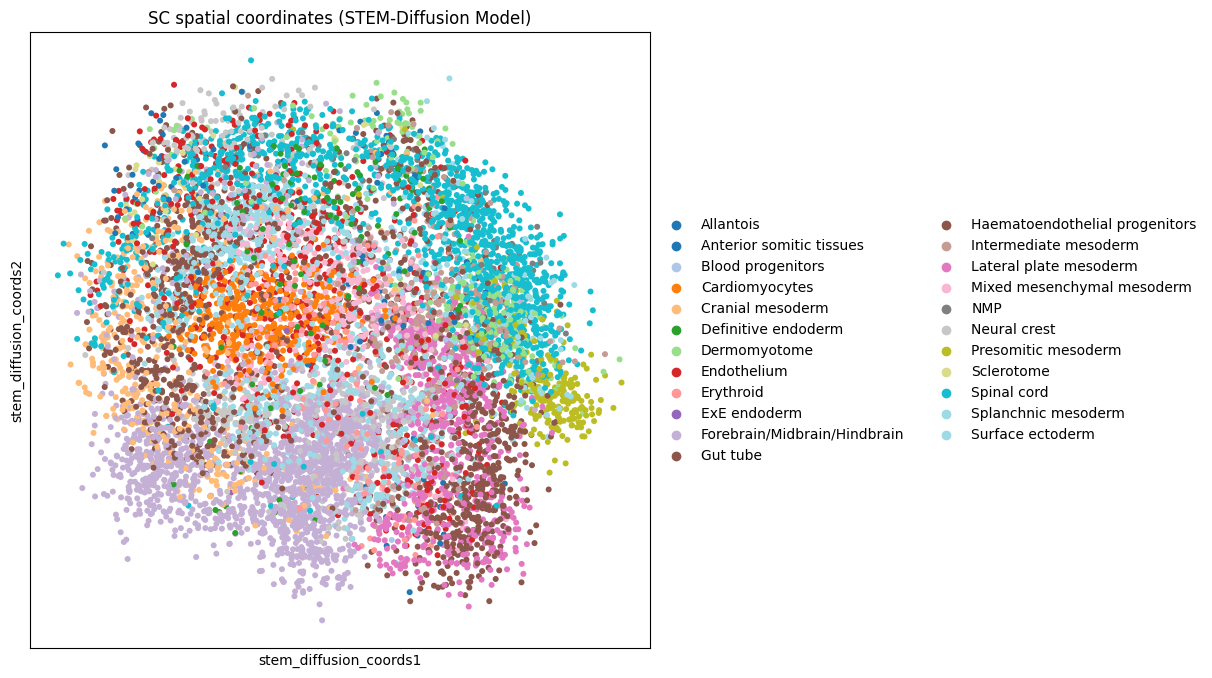

In [17]:
# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(8, 8))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)